In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import math
import json
import concurrent
import warnings
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from concurrent.futures import ThreadPoolExecutor
from IPython.core.display import display, HTML

warnings.filterwarnings("ignore")

In [2]:
# load dataset
use_columns = [
    "Month",
    "DayofMonth",
    "DayOfWeek",
    "CRSDepTime",
    "CRSArrTime",
    "UniqueCarrier",
    "FlightNum",
    "TailNum",
    "CRSElapsedTime",
    "ArrDelay",
    "Origin",
    "Dest",
    "Distance",
    "TaxiIn",
    "TaxiOut",
    "Cancelled",
    "Diverted",
]

df = pd.read_csv("datasets/airline_arrival_delay/2007_light.csv", dtype={
    "Month": str,
    "DayofMonth": str,
    "DayOfWeek": str,
    "DepTime": str,
    "CRSDepTime": str,
    "CRSArrTime": str,
    "FlightNum": str,
    "Diverted": str
}, usecols=use_columns)

def add_prefix(columns, prefix, additional_text=""):
    new_columns = []
    
    for col in columns:
        transform = ''.join([e.capitalize() for e in col.split('_')])
        
        if prefix.lower() == col.lower():
            new_columns.append(f"{prefix}{additional_text}")
        else:
            new_columns.append(f"{prefix}{additional_text}{transform}")
            
    return new_columns

df_carriers = pd.read_csv("datasets/airline_arrival_delay/carriers.csv")
df_carriers.columns = add_prefix(df_carriers.columns, "Carrier")

df_planes = pd.read_csv("datasets/airline_arrival_delay/plane-data.csv")
df_planes.columns = add_prefix(df_planes.columns, "Plane")

df_airports_from = pd.read_csv("datasets/airline_arrival_delay/airports.csv")
df_airports_from.columns = add_prefix(df_airports_from.columns, "Airport", "From")

df_airports_to = pd.read_csv("datasets/airline_arrival_delay/airports.csv")
df_airports_to.columns = add_prefix(df_airports_to.columns, "Airport", "To")

In [3]:
df = pd.merge(df, df_carriers, left_on="UniqueCarrier", right_on="CarrierCode", how="inner")
df = pd.merge(df, df_planes, left_on="TailNum", right_on="PlaneTailnum", how="inner")
df = pd.merge(df, df_airports_from, left_on="Origin", right_on="AirportFromIata", how="inner")
df = pd.merge(df, df_airports_to, left_on="Dest", right_on="AirportToIata", how="inner")

In [4]:
del df_carriers, df_planes, df_airports_from, df_airports_to

In [5]:
# I only use 3.000.000 records due to computer capacity
df = df.sample(n=3000000)

## All columns and their description

2. Month: ~~ 1-12
3. DayofMonth: ~~ 1-31
4. DayOfWeek: ~~ 1 (Monday) - 7 (Sunday)
5. CRSDepTime: ~~ scheduled departure time (local, hhmm)
6. CRSArrTime: ~~ scheduled arrival time (local, hhmm)
7. UniqueCarrier: ~~ unique carrier code
8. FlightNum: ~~ flight number
9. TailNum: ~~ plane tail number
10. CRSElapsedTime: ~~ in minutes ------ __have negative number__
11. ArrDelay: ~~ arrival delay, in minutes
12. Origin: ~~ origin IATA airport code
13. Dest: ~~ destination IATA airport code
14. Distance: ~~ in miles
15. TaxiIn: ~~ taxi in time, in minutes
16. TaxiOut: ~~ taxi out time in minutes
17. Cancelled: ~~ was the flight cancelled?
18. Diverted: ~~ 1 = yes, 0 = no

## Exploratory Data Analysis

In [6]:
# set labels for dataset
df["IsLate"] = df["ArrDelay"].apply(lambda x: x > 30)
# filter out cancelled flights
df = df[df["Cancelled"] == False]

# drop unnecessary columns after merging
df = df.drop([
    "UniqueCarrier",
    "CarrierCode",
    "TailNum",
    "PlaneTailnum",
    "Origin",
    "AirportFromIata",
    "Dest",
    "AirportToIata",
    "ArrDelay",
    "Cancelled",
    "AirportFromCountry",
    "AirportToCountry",
], axis=1)

In [7]:
# after filtering unnecessary columns, we now have only 30 features, 8 of them are numerical
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2981754 entries, 4390477 to 3672215
Data columns (total 31 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Month               object 
 1   DayofMonth          object 
 2   DayOfWeek           object 
 3   CRSDepTime          object 
 4   CRSArrTime          object 
 5   FlightNum           object 
 6   CRSElapsedTime      float64
 7   Distance            int64  
 8   TaxiIn              int64  
 9   TaxiOut             int64  
 10  Diverted            object 
 11  CarrierDescription  object 
 12  PlaneType           object 
 13  PlaneManufacturer   object 
 14  PlaneIssueDate      object 
 15  PlaneModel          object 
 16  PlaneStatus         object 
 17  PlaneAircraftType   object 
 18  PlaneEngineType     object 
 19  PlaneYear           object 
 20  AirportFrom         object 
 21  AirportFromCity     object 
 22  AirportFromState    object 
 23  AirportFromLat      float64
 24  AirportFromLong   

In [8]:
df.describe()

,CRSElapsedTime,Distance,TaxiIn,TaxiOut,AirportFromLat,AirportFromLong,AirportToLat,AirportToLong
count,2.981753e+06,2.981754e+06,2.981754e+06,2.981754e+06,2.981754e+06,2.981754e+06,2.981754e+06,2.981754e+06
mean,1.289691e+02,7.356270e+02,6.810447e+00,1.665807e+01,3.673666e+01,-9.555378e+01,3.674325e+01,-9.554137e+01
std,7.149604e+01,5.714415e+02,5.101102e+00,1.176908e+01,5.755354e+00,1.838389e+01,5.756697e+00,1.838287e+01
min,1.000000e+00,1.100000e+01,0.000000e+00,0.000000e+00,1.770189e+01,-1.766460e+02,1.770189e+01,-1.766460e+02
25%,7.800000e+01,3.250000e+02,4.000000e+00,1.000000e+01,3.343417e+01,-1.119778e+02,3.343417e+01,-1.119778e+02
50%,1.100000e+02,5.870000e+02,6.000000e+00,1.400000e+01,3.750517e+01,-8.997667e+01,3.750517e+01,-8.997667e+01
75%,1.600000e+02,9.640000e+02,8.000000e+00,1.900000e+01,4.077724e+01,-8.144247e+01,4.077724e+01,-8.131603e+01
max,6.600000e+02,4.962000e+03,4.860000e+02,4.000000e+02,7.128545e+01,-6.479856e+01,7.128545e+01,-6.479856e+01


#### Exploration

__CrsElapsedTime:__ Negative numbers means flying back in time zone (bay ngược múi giờ) (but in another dataset)

In [9]:
df.describe(include="O").T

,count,unique,top,freq
Month,2981754,12,8,266874
DayofMonth,2981754,31,12,100505
DayOfWeek,2981754,7,1,446087
CRSDepTime,2981754,1180,600,52509
CRSArrTime,2981754,1383,1930,10860
FlightNum,2981754,7554,16,2221
Diverted,2981754,2,0,2974837
CarrierDescription,2981754,19,Southwest Airlines Co.,468743
PlaneType,2828123,5,Corporation,2808585
PlaneManufacturer,2828123,35,BOEING,1167314


In [10]:
df.head(5).T

,4390477,1004554,3865735,4966165,2363112
Month,3,10,5,1,9
DayofMonth,11,23,7,10,5
DayOfWeek,7,2,1,3,3
CRSDepTime,1400,1715,725,1840,1435
CRSArrTime,1510,1835,1014,2005,1559
FlightNum,2174,2091,292,1733,7271
CRSElapsedTime,70,80,169,85,84
Distance,214,371,938,409,372
TaxiIn,6,3,4,5,5
TaxiOut,13,7,33,22,19


In [11]:
print(f"Total rows: {len(df)}")

Total rows: 2981754


### Check missing values

In [12]:
# list all columns with their total missing values
nan_summary = df.isnull().sum()
nan_summary

Month                      0
DayofMonth                 0
DayOfWeek                  0
CRSDepTime                 0
CRSArrTime                 0
FlightNum                  0
CRSElapsedTime             1
Distance                   0
TaxiIn                     0
TaxiOut                    0
Diverted                   0
CarrierDescription         0
PlaneType             153631
PlaneManufacturer     153631
PlaneIssueDate        153631
PlaneModel            153631
PlaneStatus           153631
PlaneAircraftType     153631
PlaneEngineType       153631
PlaneYear             153631
AirportFrom                0
AirportFromCity         2104
AirportFromState        2104
AirportFromLat             0
AirportFromLong            0
AirportTo                  0
AirportToCity           2194
AirportToState          2194
AirportToLat               0
AirportToLong              0
IsLate                     0
dtype: int64

In [7]:
# the missing value only 5% which is not really significant => drop all missing value
df = df.dropna()

### Heatmap visualization

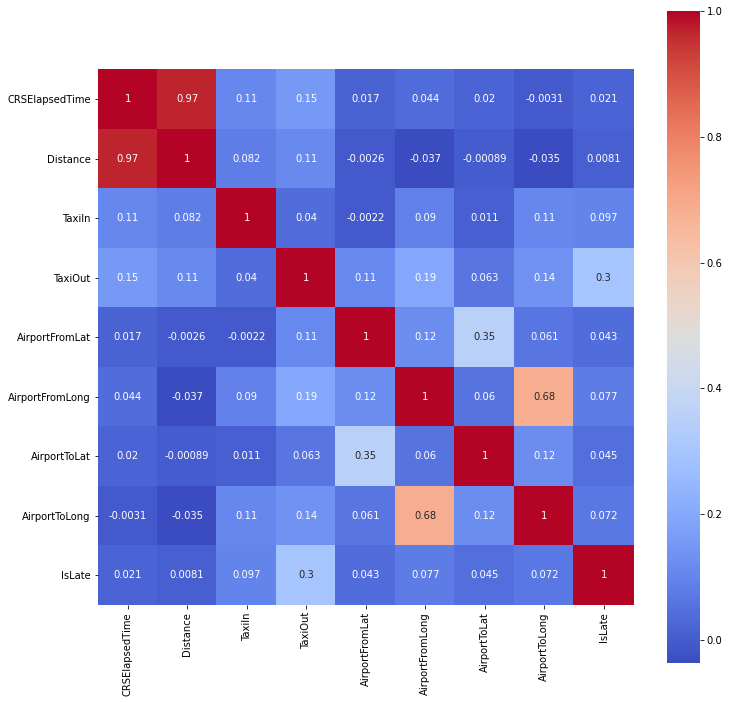

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
sns.heatmap(df.corr(), annot=True, square=True, cmap="coolwarm", ax=ax);

# the scheduled time & actual time is strictly correlated -> should get the difference
# airtime & distance are also correlated with actual & schedule elapsed time

### Visualization numerical data based on IsLate label

In [8]:
numerical_features = [
    "CRSElapsedTime",
    "Distance",
    "TaxiIn",
    "TaxiOut",
    "AirportFromLat",
    "AirportFromLong",
    "AirportToLat",
    "AirportToLong"
]

<Figure size 720x504 with 0 Axes>

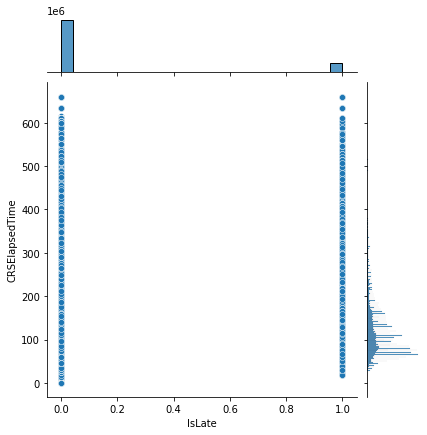

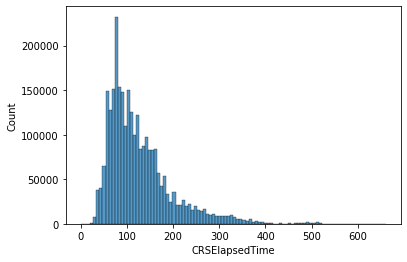

<Figure size 720x504 with 0 Axes>

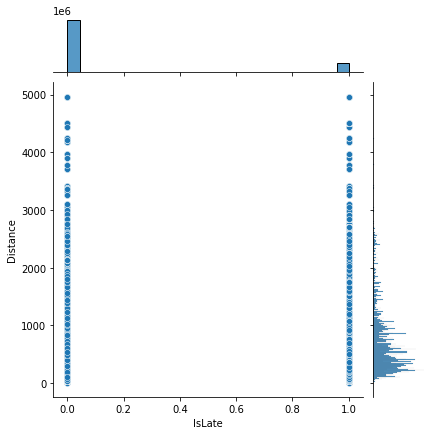

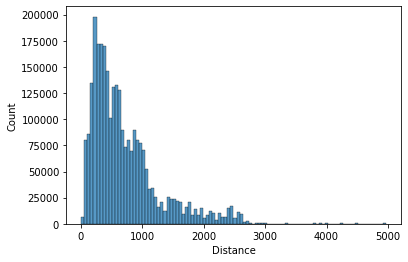

<Figure size 720x504 with 0 Axes>

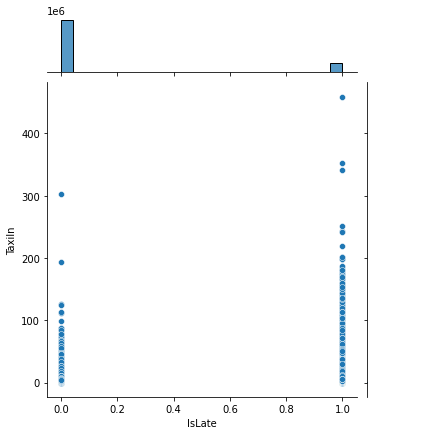

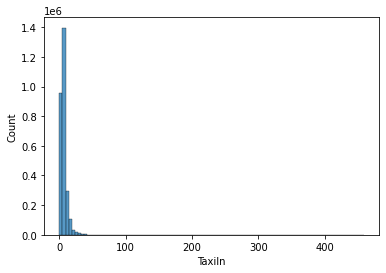

<Figure size 720x504 with 0 Axes>

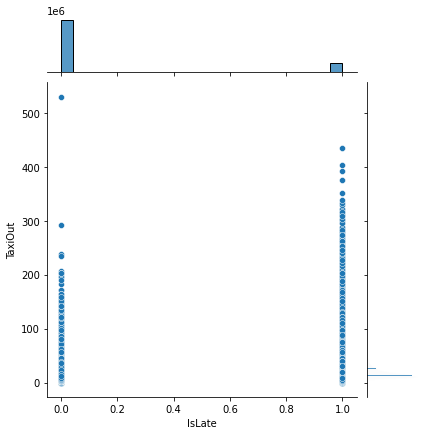

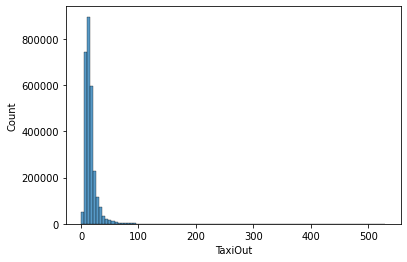

<Figure size 720x504 with 0 Axes>

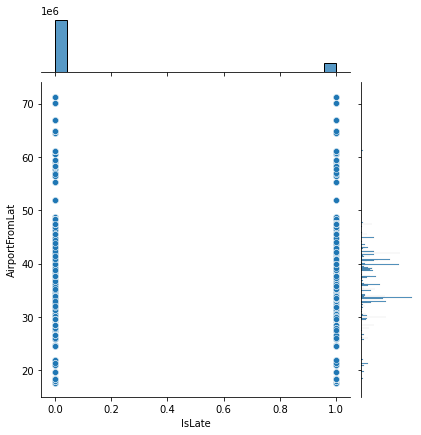

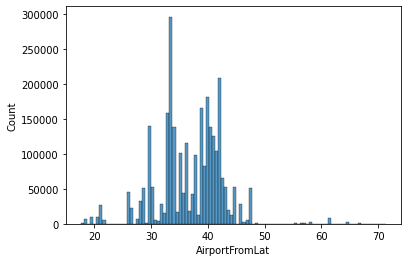

<Figure size 720x504 with 0 Axes>

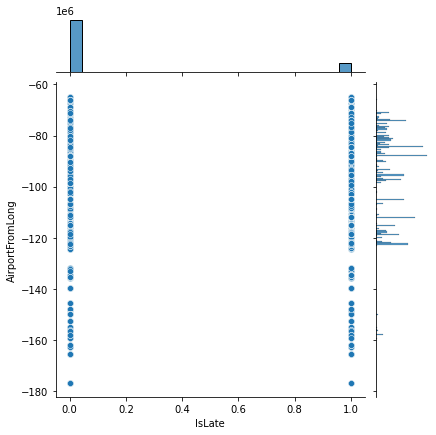

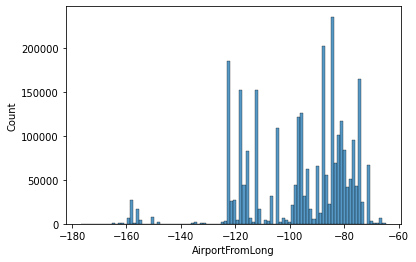

<Figure size 720x504 with 0 Axes>

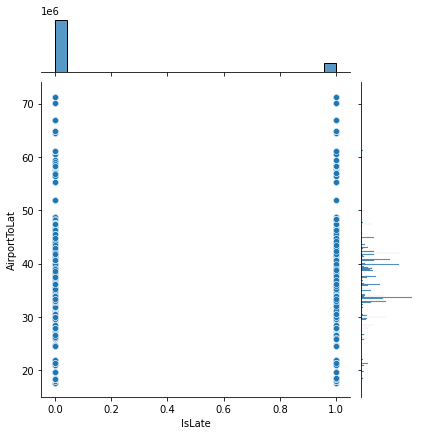

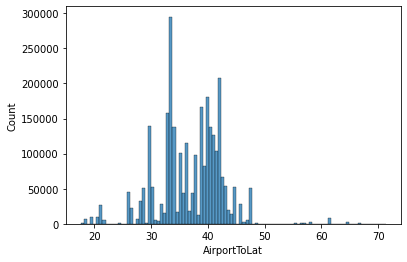

<Figure size 720x504 with 0 Axes>

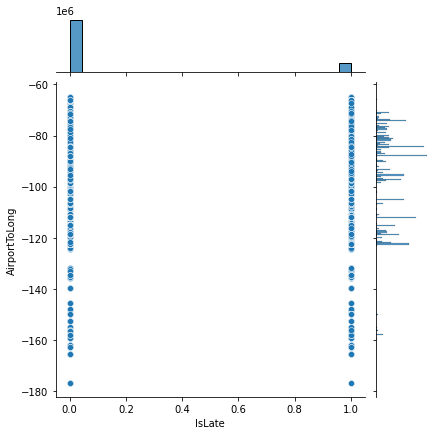

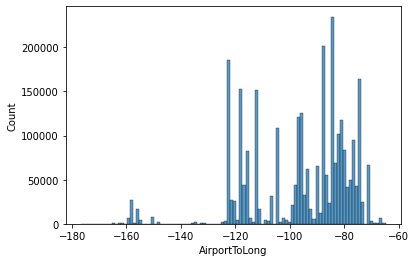

In [8]:
for column in numerical_features:
    plt.figure(figsize=(10, 7))
    display(HTML(f"<h4>{column}</h4>"))
    
    sns.jointplot(data=df, x="IsLate", y=column);
    plt.show()
    
    sns.histplot(df[column], bins=100);
    plt.show()

# Via data population, I can see that only the features like TaxiIn, Taxiout affect the lateness directly
# Significantly, distance doesn't show any relation with IsLate

### Visualization categorical data based on IsLate label

In [10]:
def split_hour(date):
    return date[:2]

def add_prefix_to_date(day):
    if len(day) == 1:
        return f"0{day}"
    
    return day

def add_prefix_to_time(time):
    return time.rjust(4, "0")

# df = df_backup.copy()
df["CRSDepTime"] = df["CRSDepTime"].apply(add_prefix_to_time)
df["CRSArrTime"] = df["CRSArrTime"].apply(add_prefix_to_time)
df["CRSDepTime_Hour"] = df["CRSDepTime"].apply(split_hour)
df["CRSArrTime_Hour"] = df["CRSArrTime"].apply(split_hour)
df["Month"] = df["Month"].apply(add_prefix_to_date)
df["DayofMonth"] = df["DayofMonth"].apply(add_prefix_to_date)
df["Diverted"] = df["Diverted"].map({"0": "Non-diverted", "1": "Diverted"})
df["PlaneIssueYear"] = df["PlaneIssueDate"].apply(lambda e: e.split("/")[-1])

# diverted is all NaN column, so I would drop this feature
df = df.drop(["CRSDepTime", "CRSArrTime", "PlaneIssueDate", "Diverted"], axis=1)

In [17]:
def calculate_categorical_percentage(df, column):
    visualize = df.groupby(column)["IsLate"].value_counts().sort_index().to_frame()
    visualize["TotalFlights"] = df.groupby(column)["IsLate"].value_counts().values
    visualize = visualize.drop(["IsLate"], axis=1).sort_index().reset_index()
    
    column_values1 = visualize[visualize["IsLate"] == True][column].unique()
    column_values2 = visualize[visualize["IsLate"] == False][column].unique()
    
    column_values = list(set(column_values1) & set(column_values2))
    column_values.sort()
    
    total_flights = visualize[visualize[column].isin(column_values)].groupby(column)["TotalFlights"].sum()
    is_late = visualize[(visualize["IsLate"] == True) & (visualize[column].isin(column_values))]["TotalFlights"]
    is_not_late = visualize[(visualize["IsLate"] == False) & (visualize[column].isin(column_values))]["TotalFlights"]

    is_late_percentage = [value / total_flights[i] * 100 for i, value in enumerate(is_late)]
    is_not_late_percentage = [value / total_flights[i] * 100 for i, value in enumerate(is_not_late)]
    
    return visualize, column_values, is_late_percentage, is_not_late_percentage

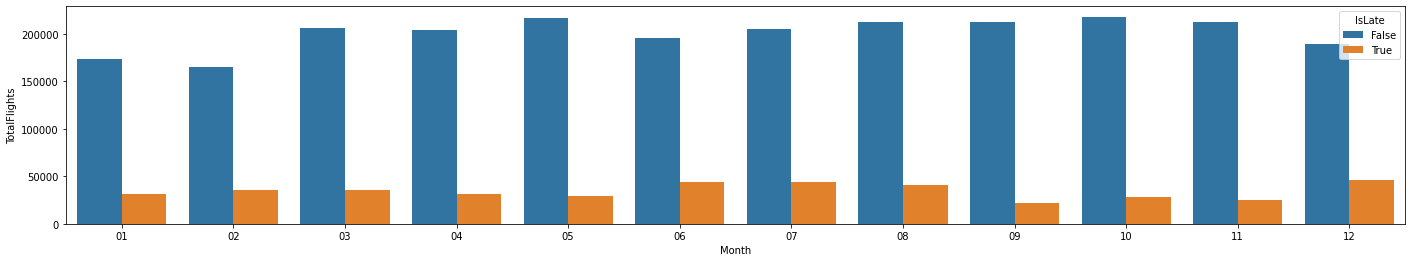

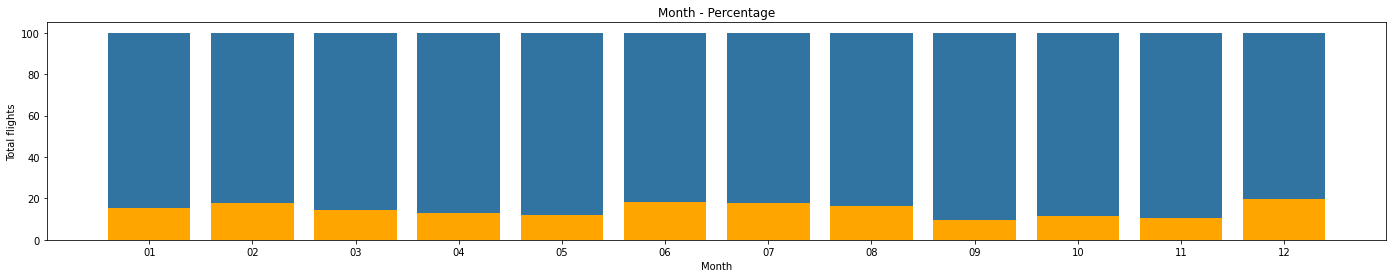

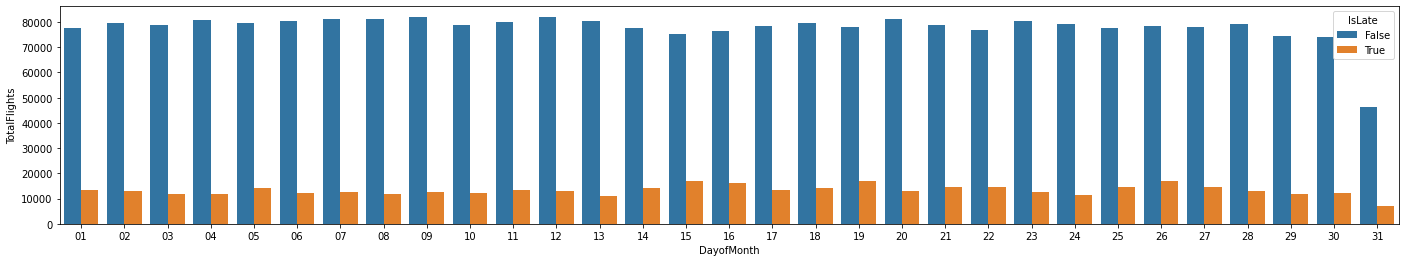

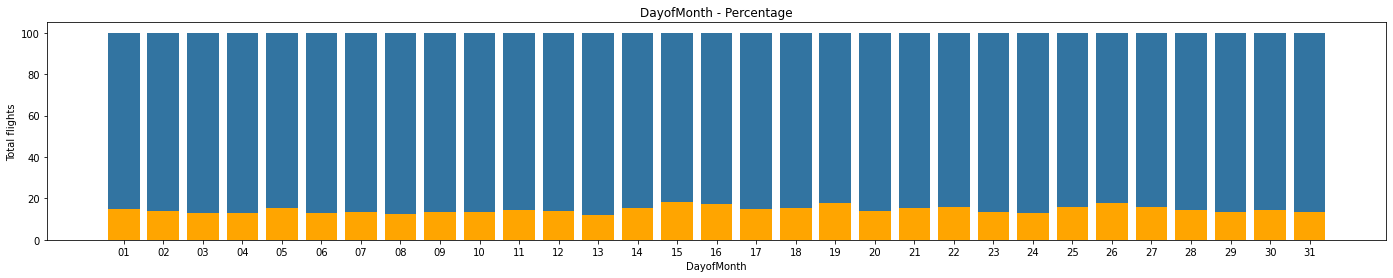

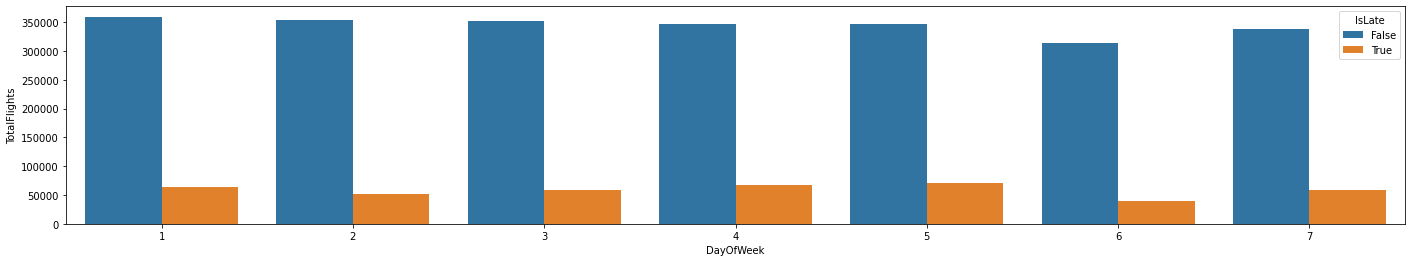

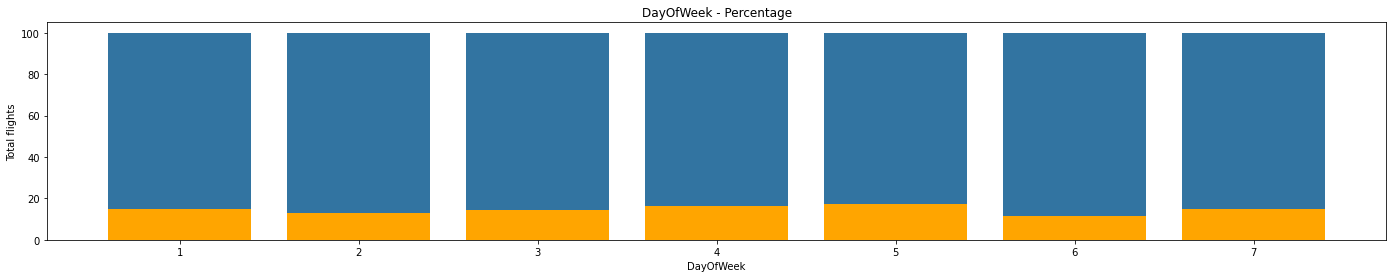

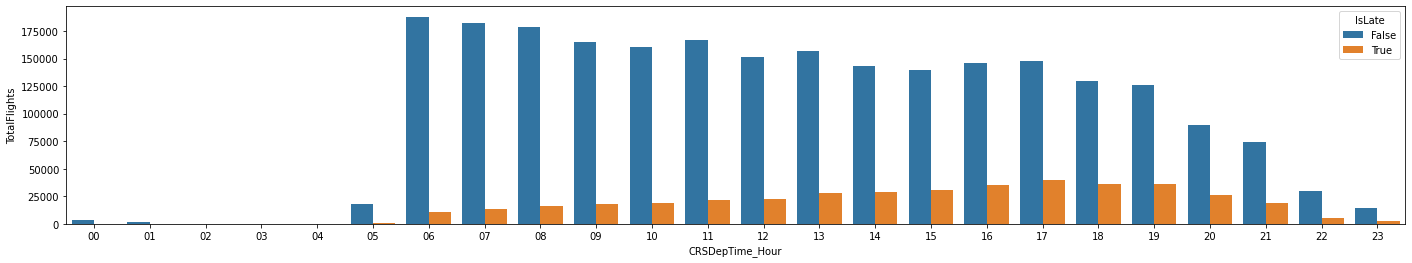

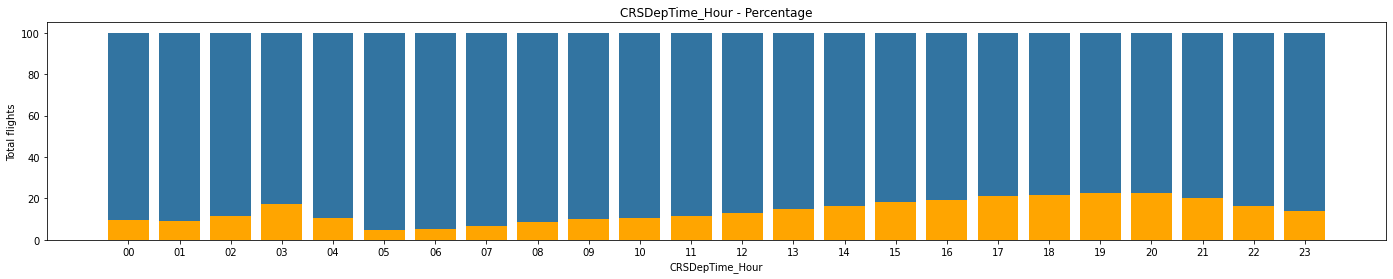

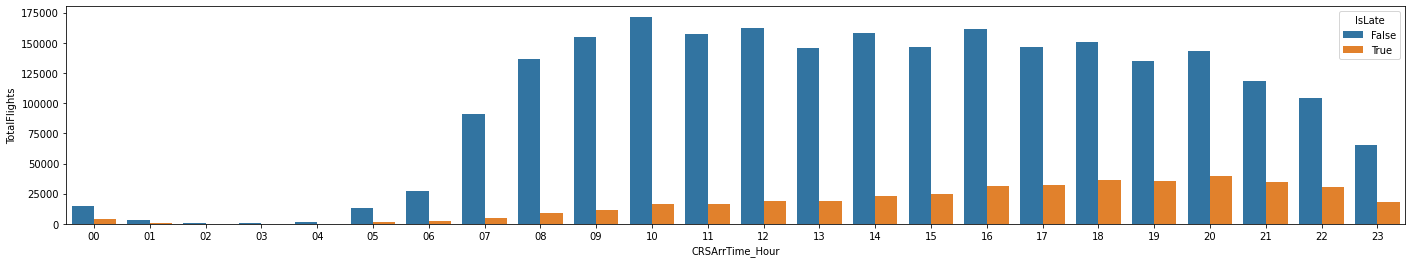

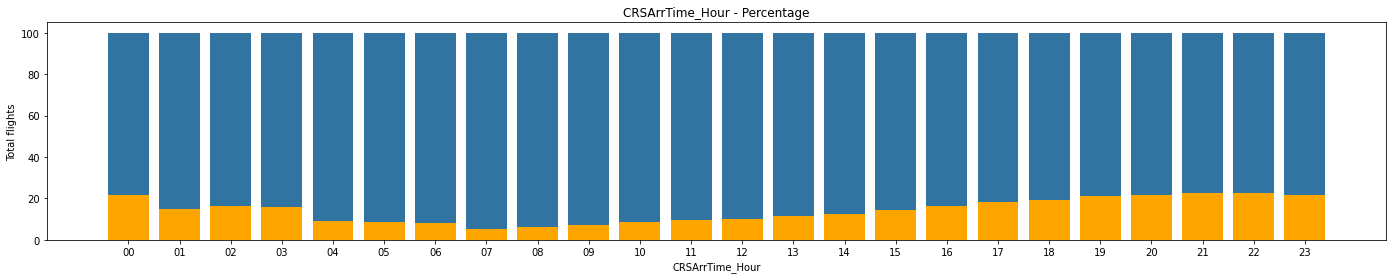

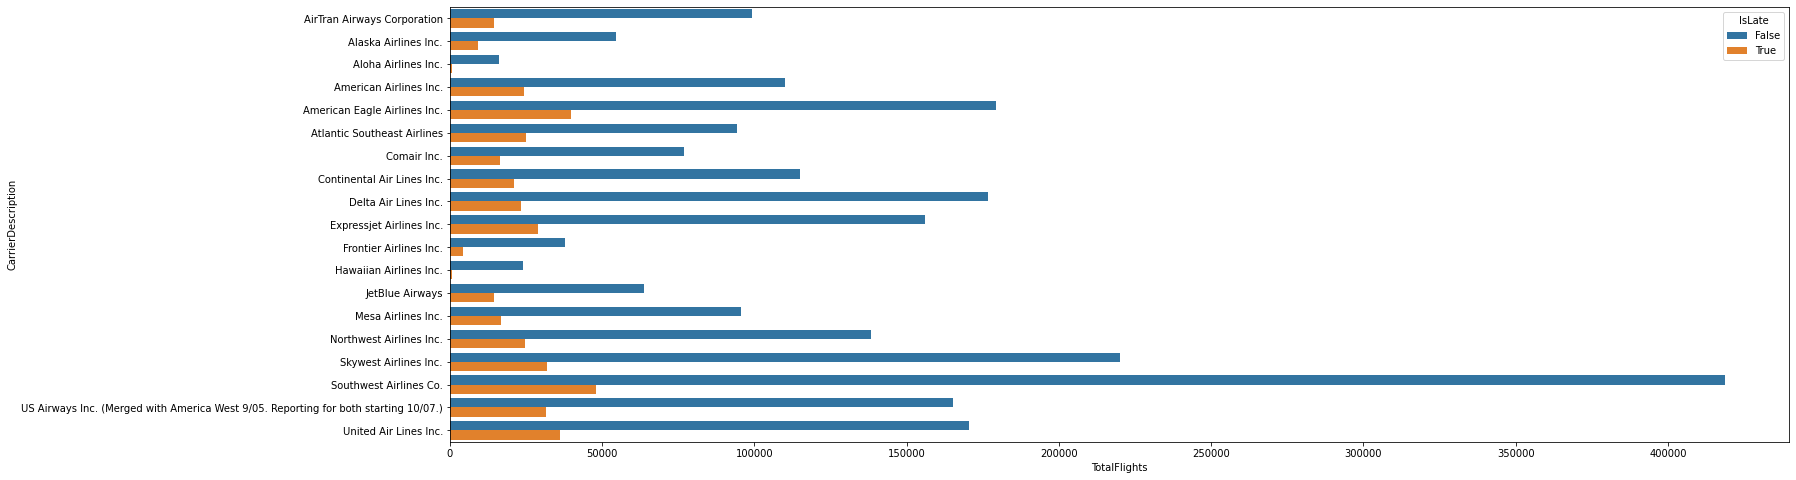

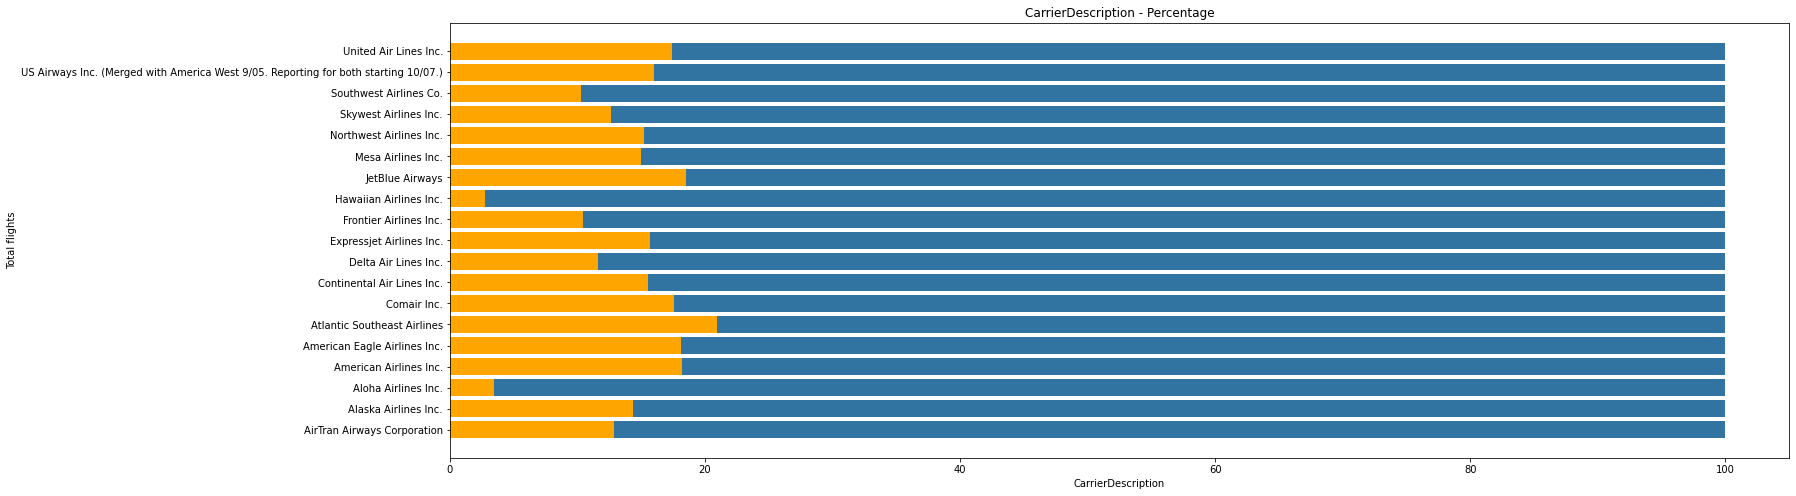

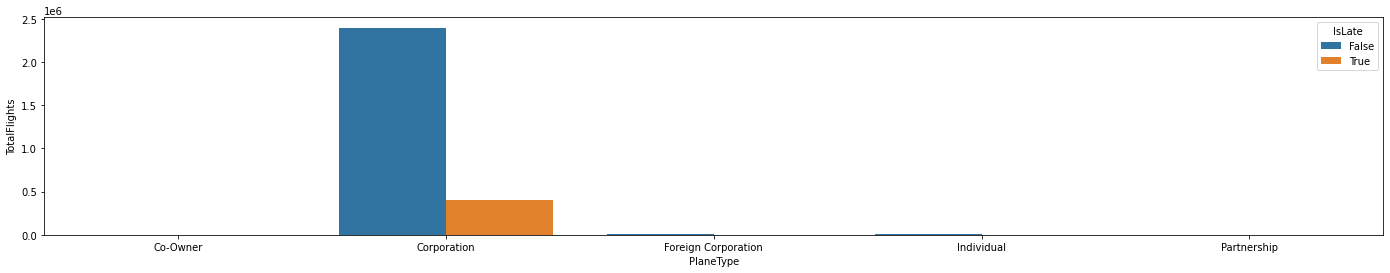

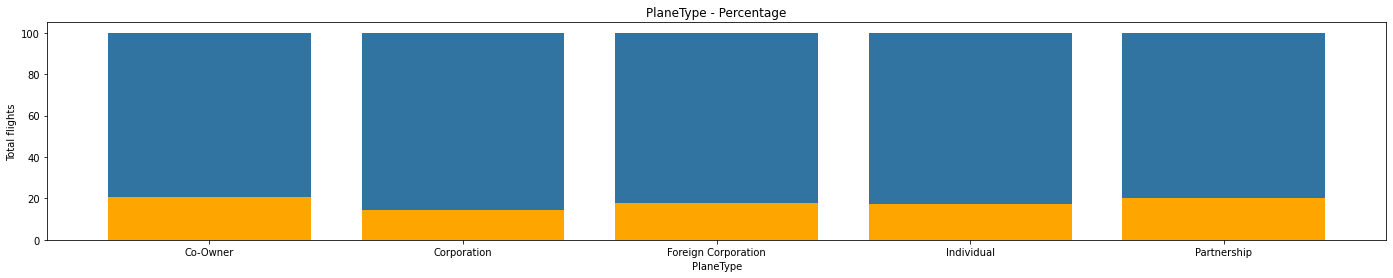

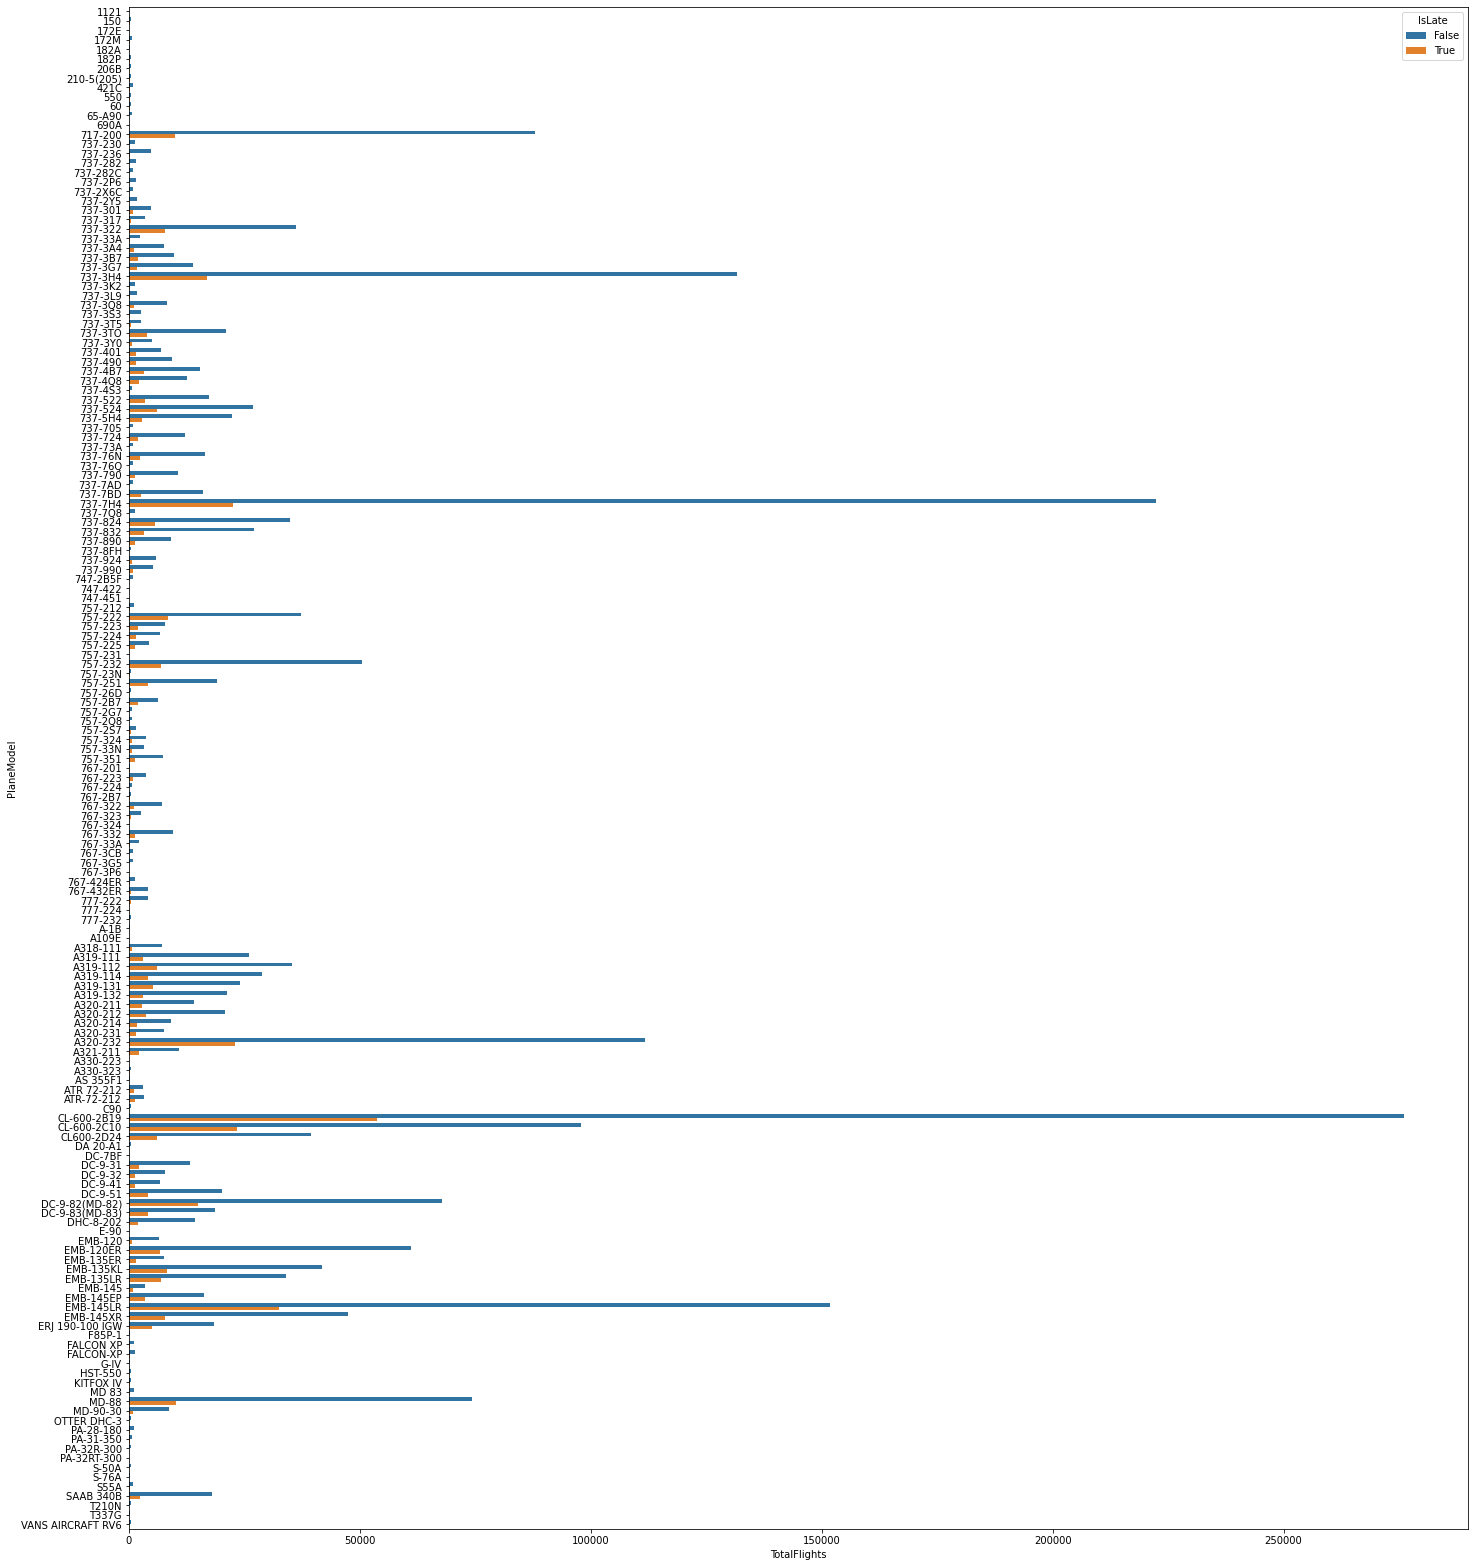

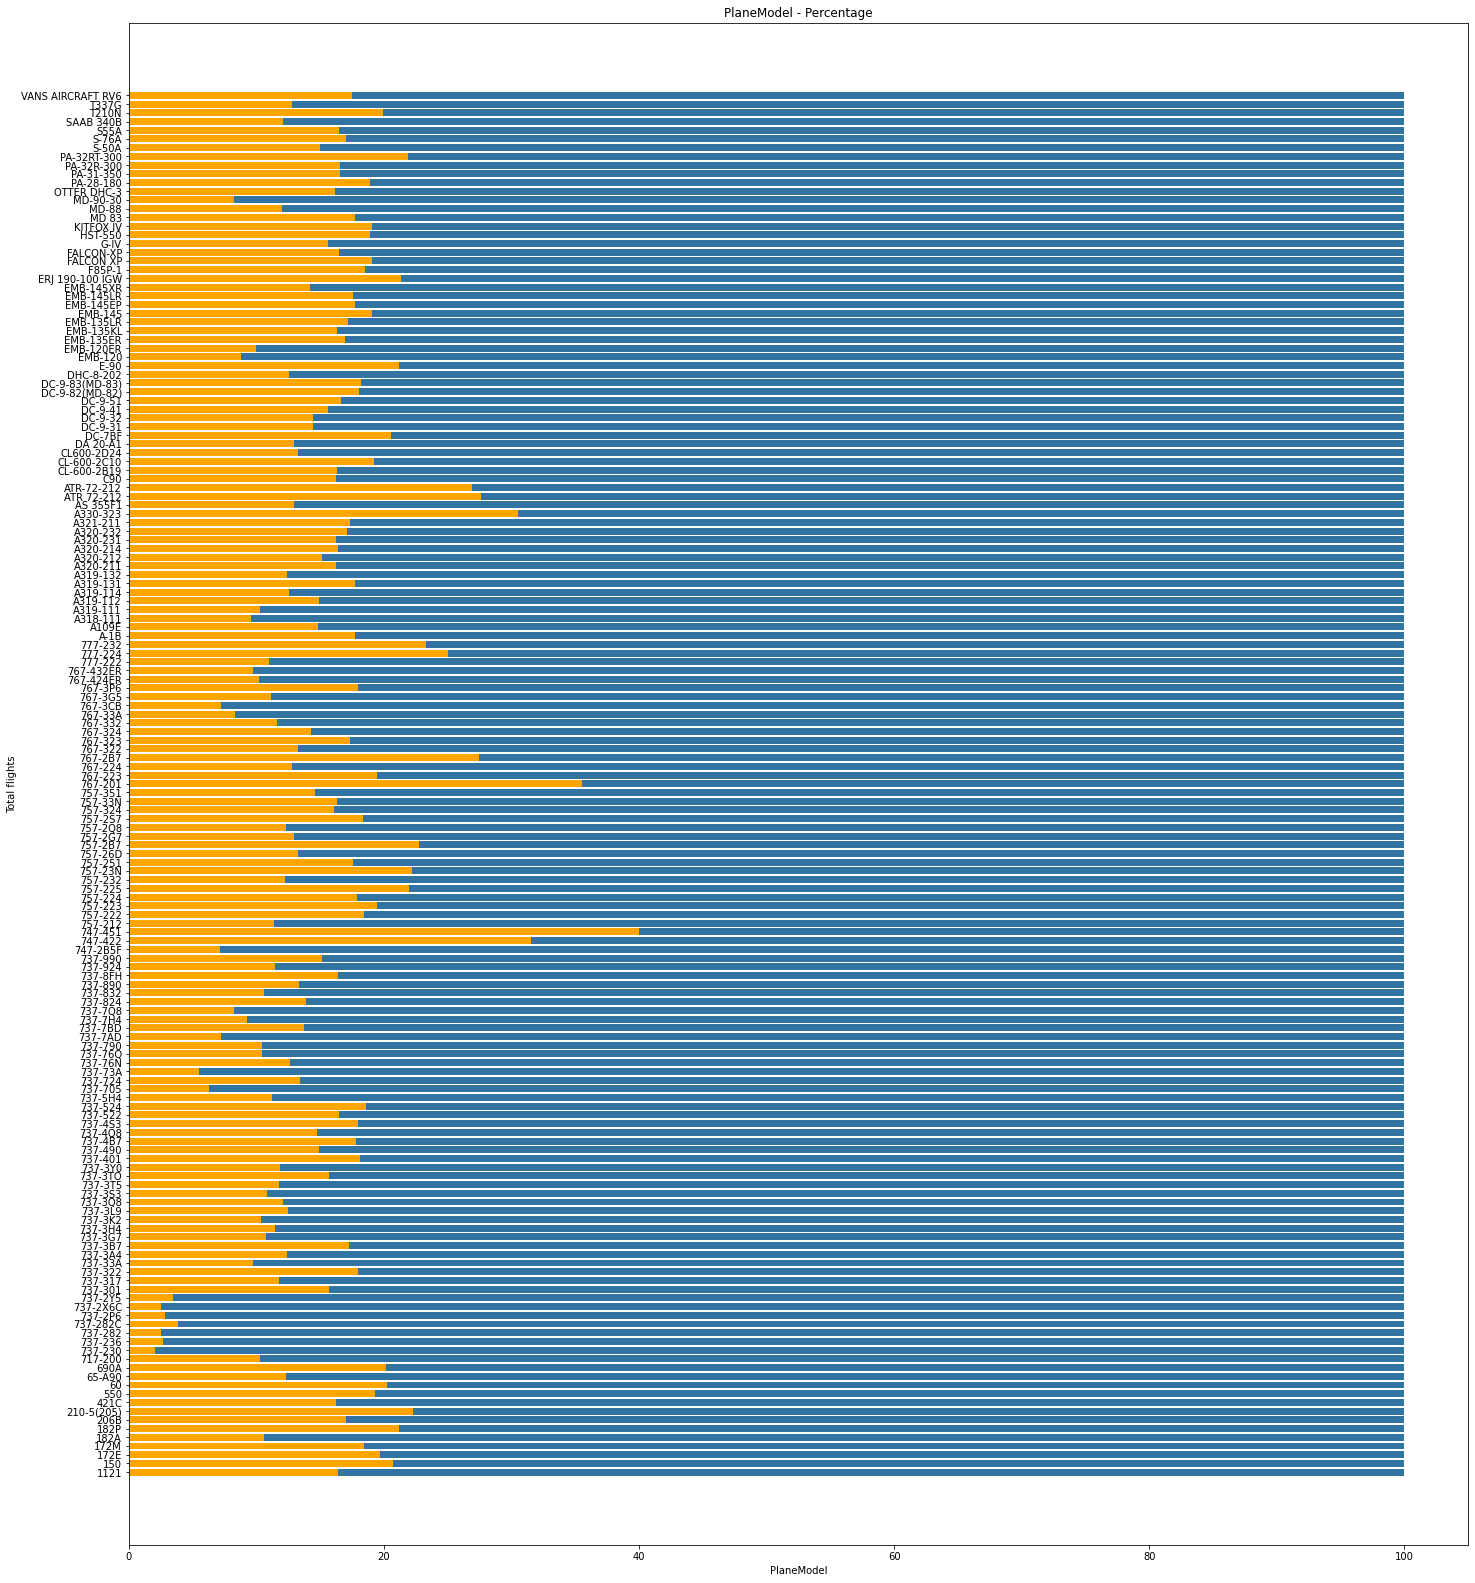

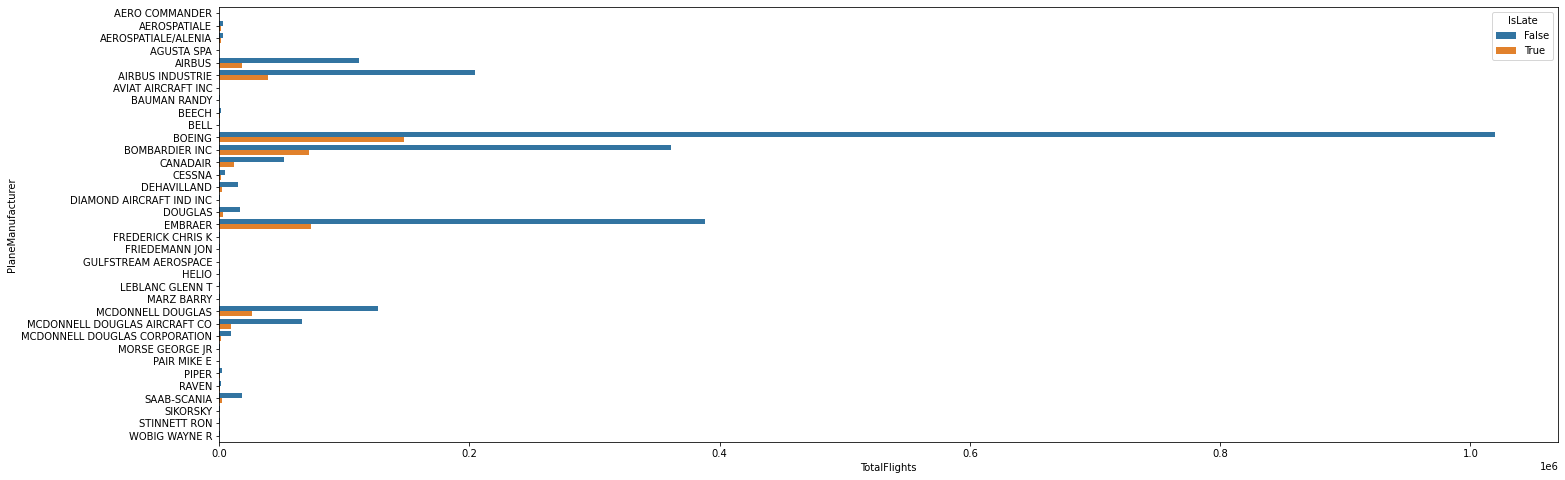

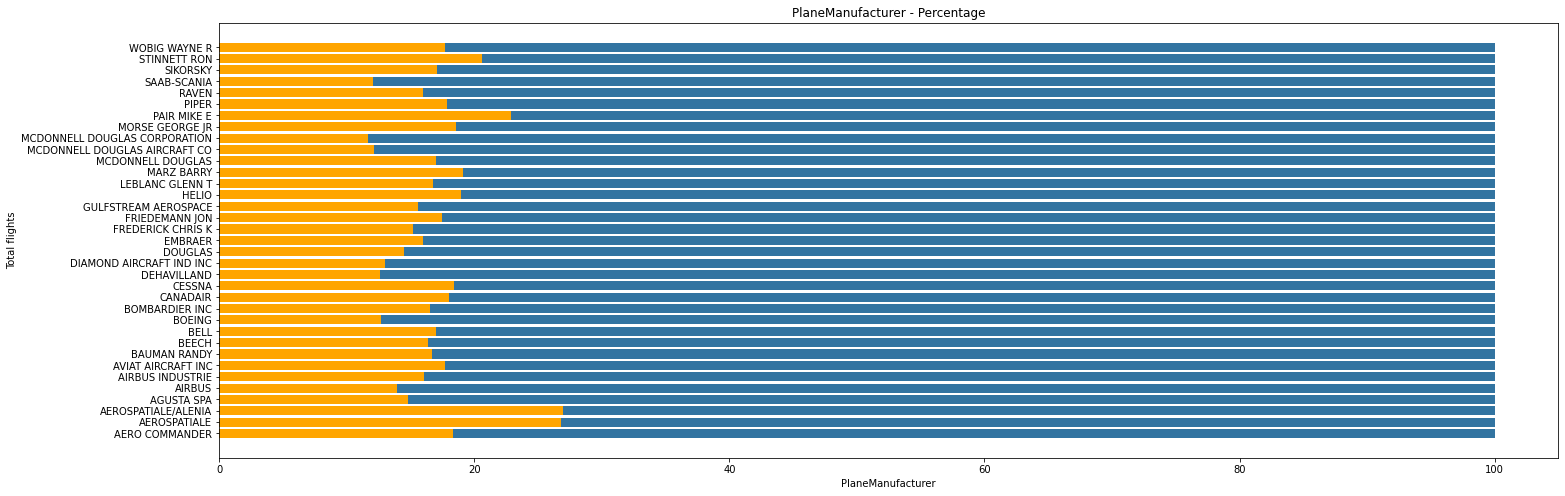

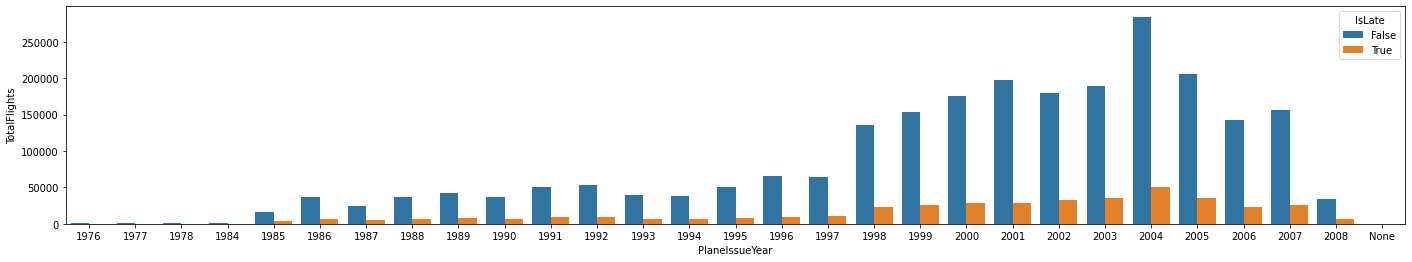

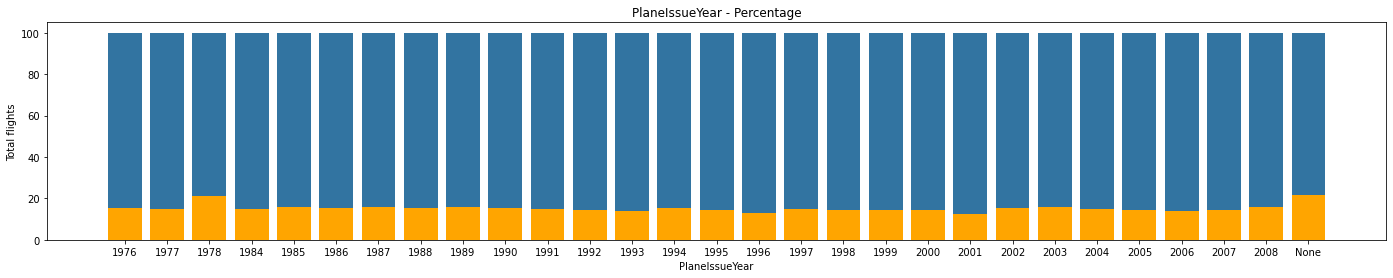

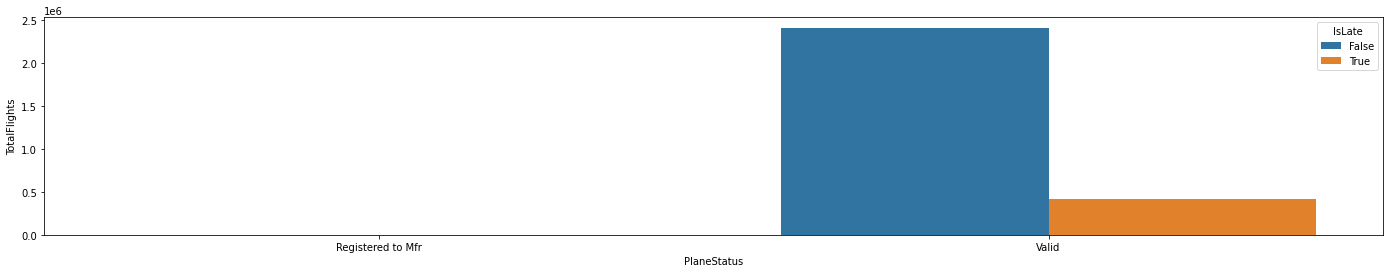

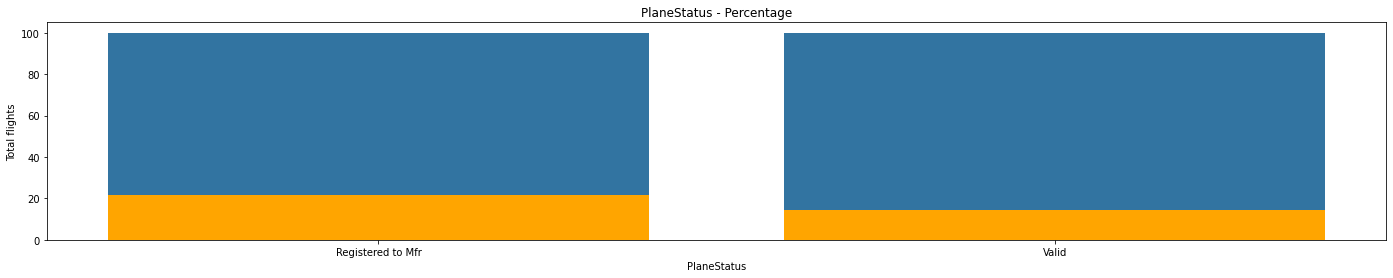

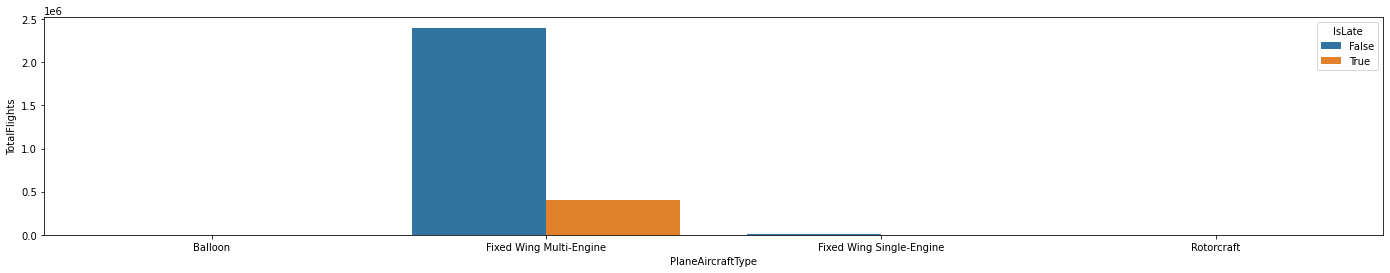

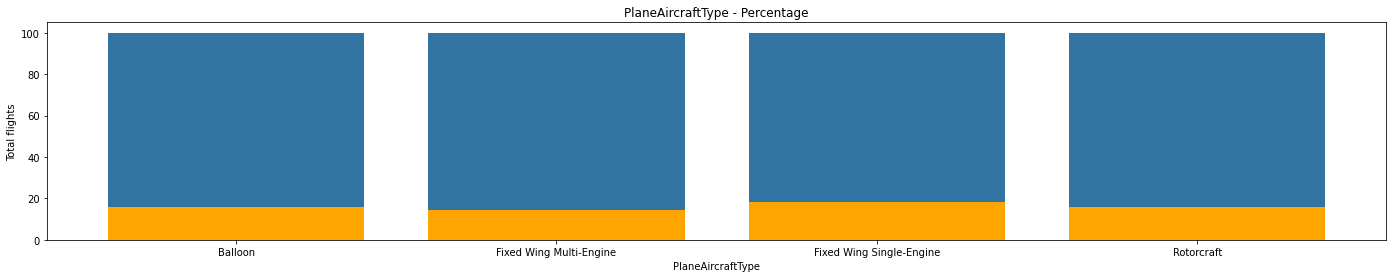

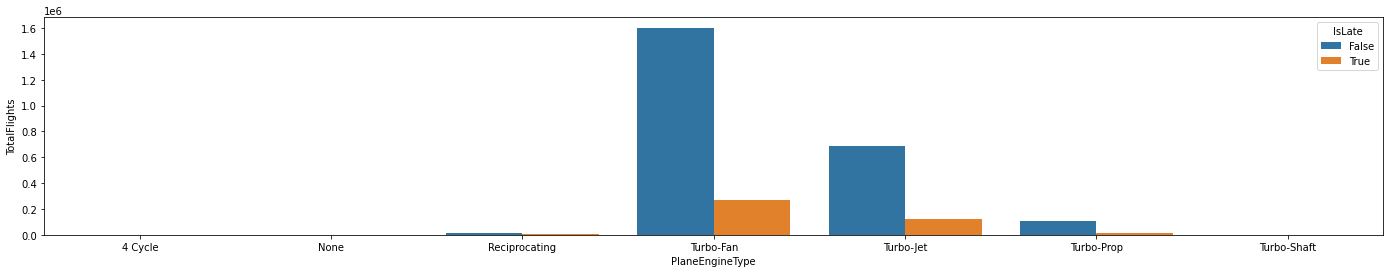

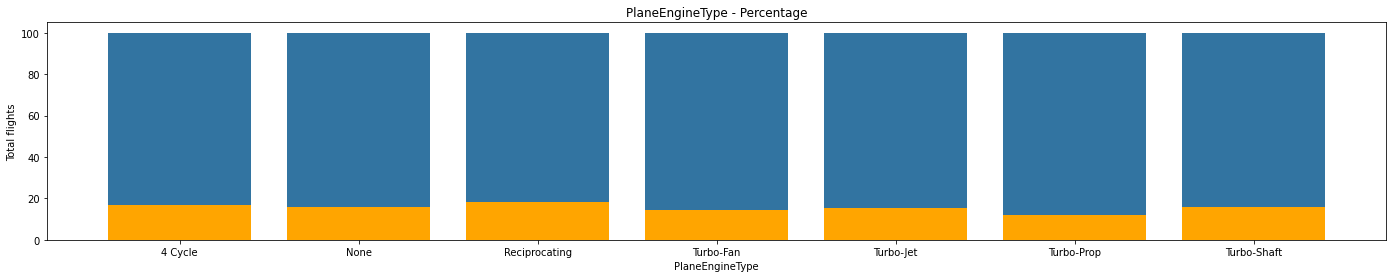

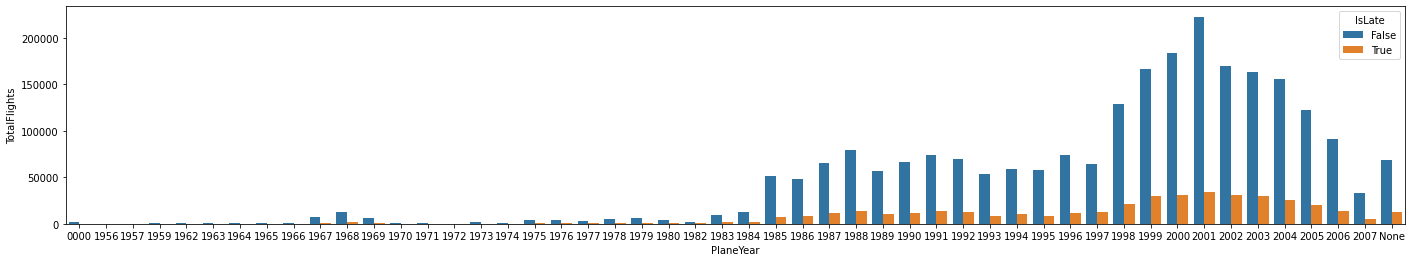

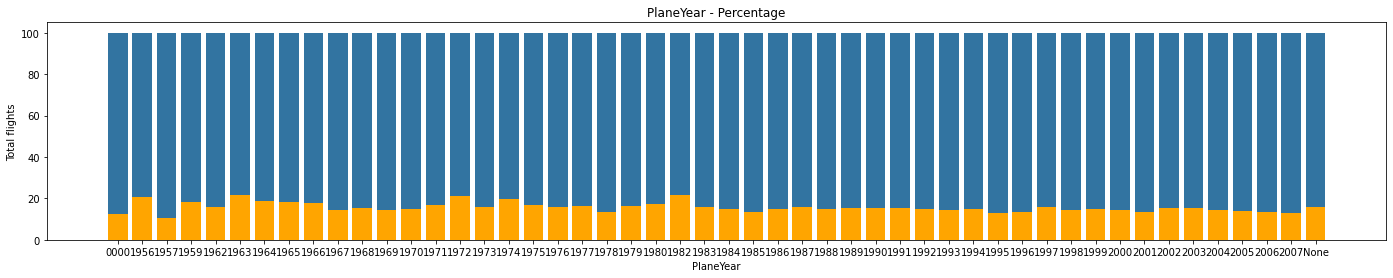

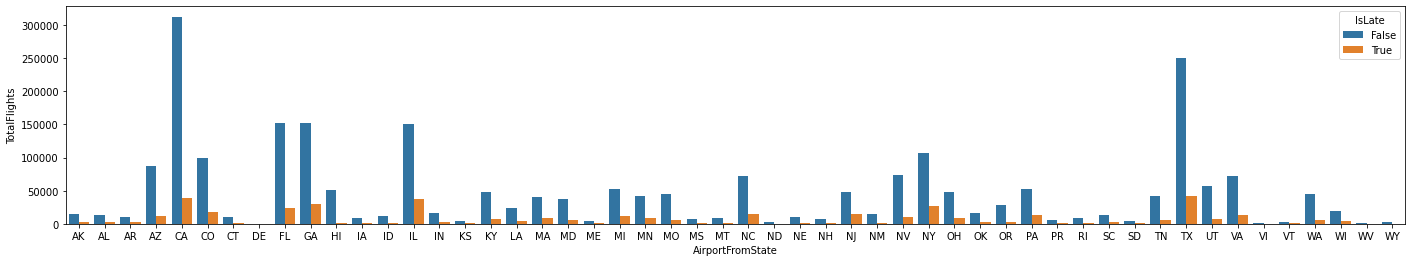

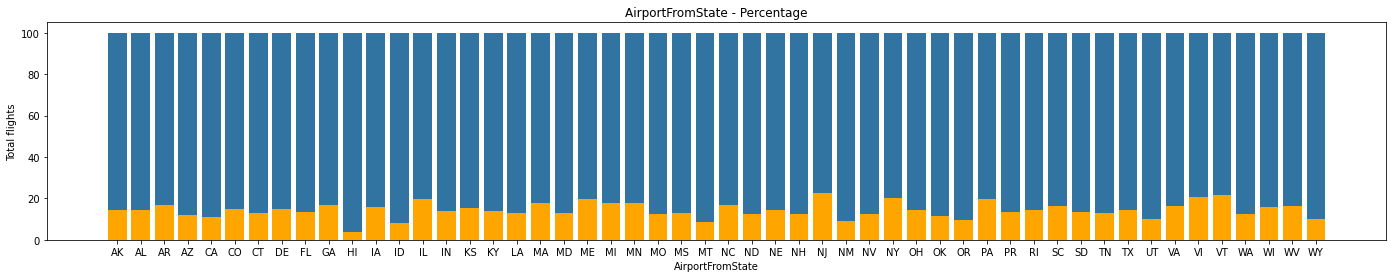

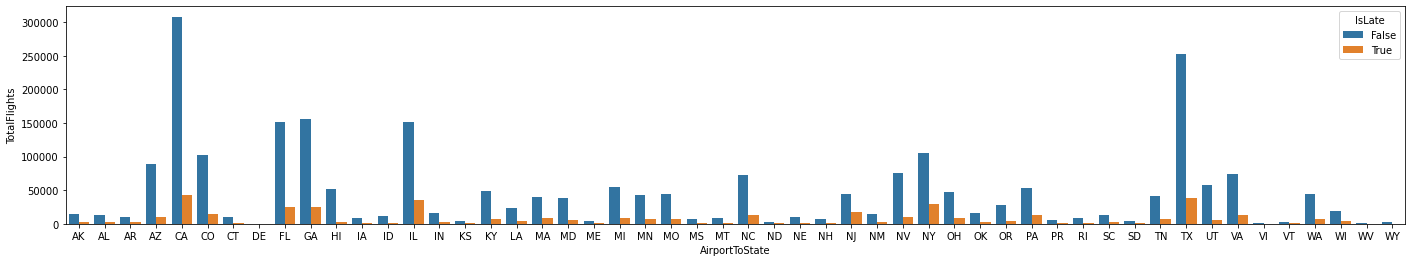

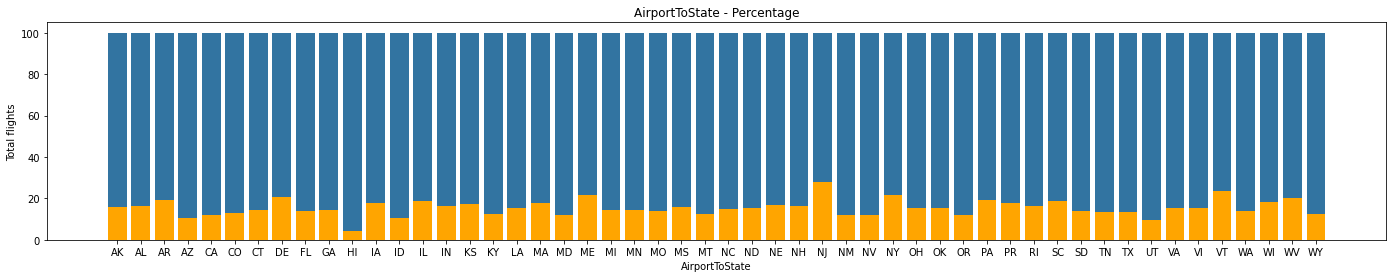

In [18]:
categorical_features = [
    "Month",
    "DayofMonth",
    "DayOfWeek",
    "CRSDepTime_Hour",
    "CRSArrTime_Hour",
    "CarrierDescription",
    "PlaneType",
    "PlaneModel",
    "PlaneManufacturer",
    "PlaneIssueYear",
    "PlaneStatus",
    "PlaneAircraftType",
    "PlaneEngineType",
    "PlaneYear",
    "AirportFromState",
    "AirportToState",
]
barh_columns = [
    "PlaneModel",
    "PlaneManufacturer",
    "CarrierDescription"
]

for column in categorical_features:
    visualize, column_values, is_late_percentage, is_not_late_percentage = calculate_categorical_percentage(df, column)
    
    display(HTML(f"<h4>{column}</h4>"))

    # show IsLate percentage
    
    
    if column in barh_columns:
        height = 8 if column != "PlaneModel" else 28
        
        plt.figure(figsize=(24, height))
        sns.barplot(x="TotalFlights", hue="IsLate", y=column, data=visualize);
        plt.show()
        
        plt.figure(figsize=(24, height))
        plt.barh(column_values, is_late_percentage, color="orange")
        plt.barh(column_values, is_not_late_percentage, left=is_late_percentage, color="#3274a1")
    else:
        plt.figure(figsize=(24, 4))
        sns.barplot(x=column, hue="IsLate", y="TotalFlights", data=visualize);
        plt.show()
    
        plt.figure(figsize=(24, 4))
        plt.bar(column_values, is_late_percentage, color="orange")
        plt.bar(column_values, is_not_late_percentage, bottom=is_late_percentage, color="#3274a1")
        
    plt.xlabel(column)
    plt.ylabel("Total flights")
    plt.title(f"{column} - Percentage")
    plt.show()

From the visualized data, we can see that the late percentage of Month, CRSDepTime_Hour, CarrierDescription, PlaneManufacturer, AirportFromState, AirportToState is deviated and unstable, so these features should be kept in training.

Even though the PlaneModel feature's percentage is different between models, but the unique value quantity is remarkable so I will drop this feature

In contrast, DayofMonth, DayOfWeek, PlaneType, PlaneIssueYear, PlaneStatus, PlaneAircraftType, PlaneYear don't show any promising influence to the lateness

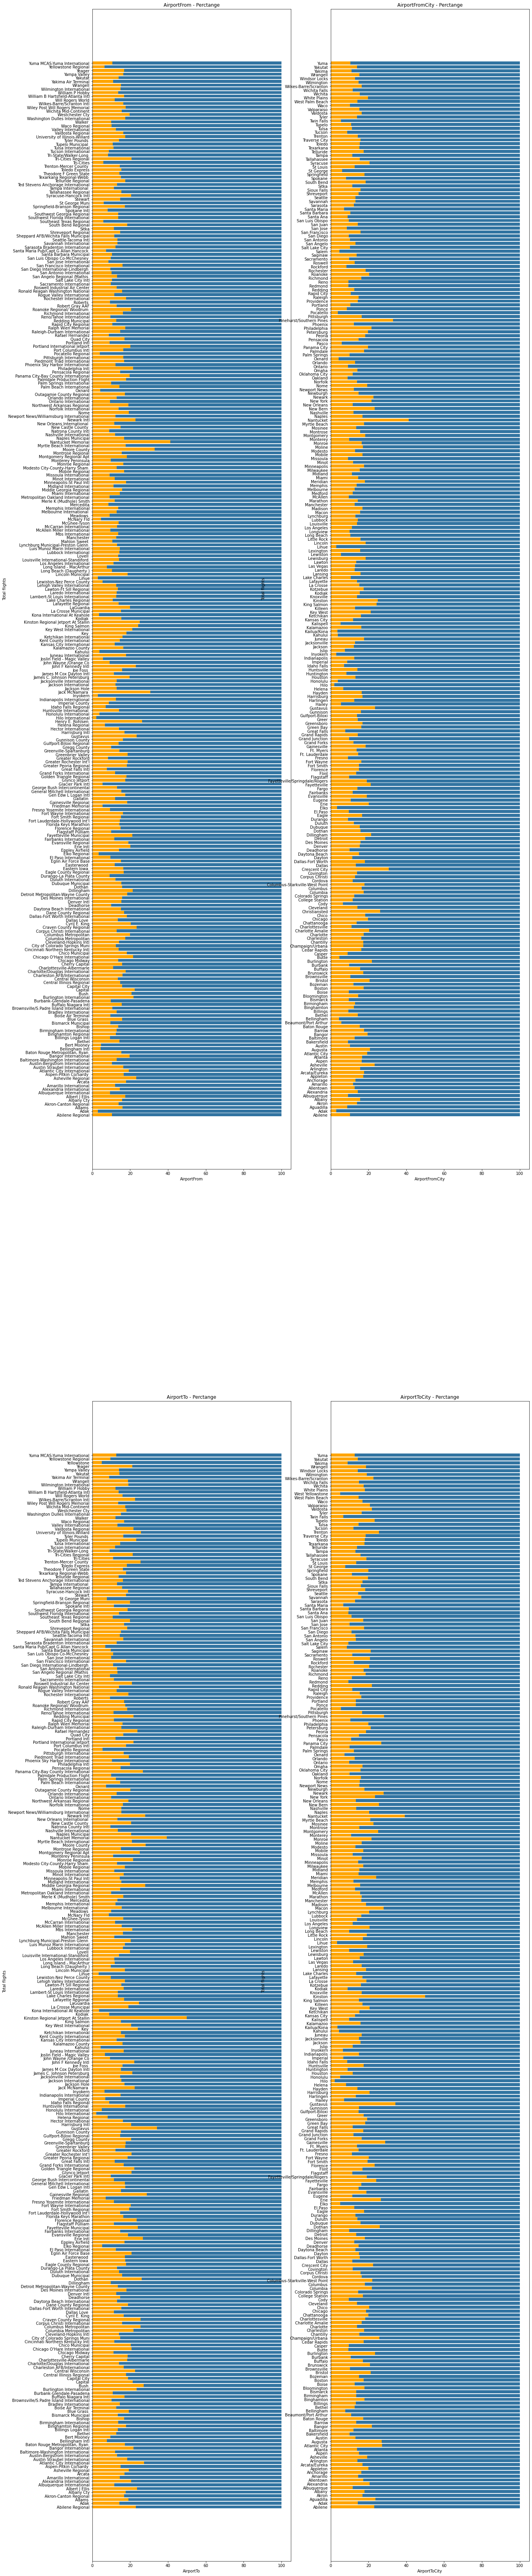

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(20, 120))
columns = [["AirportFrom", "AirportFromCity"], ["AirportTo", "AirportToCity"]]

for index, (column1, column2) in enumerate(columns):
    _, column_values, is_late_percentage, is_not_late_percentage = calculate_categorical_percentage(df, column1)

    ax[index][0].barh(column_values, is_late_percentage, color="orange")
    ax[index][0].barh(column_values, is_not_late_percentage, left=is_late_percentage, color="#3274a1")
    ax[index][0].set_xlabel(column1)
    ax[index][0].set_ylabel("Total flights")
    ax[index][0].set_title(f"{column1} - Perctange")

    _, column_values, is_late_percentage, is_not_late_percentage = calculate_categorical_percentage(df, column2)
    ax[index][1].barh(column_values, is_late_percentage, color="orange")
    ax[index][1].barh(column_values, is_not_late_percentage, left=is_late_percentage, color="#3274a1")
    ax[index][1].set_xlabel(column2)
    ax[index][1].set_ylabel("Total flights")
    ax[index][1].set_title(f"{column2} - Perctange")

plt.show()

<!--  "Origin", "Dest",  -->
I guess that the Airport and city features also contribute to the lateness. Because there are bad and good conditioning airports, large and small area, easily for flights to depart and land. But it has so many unique values, so we shouldn't keep this feature.

### Hypothesis Testing

The null hypothesis for chi2 test is that "two categorical variables are independent". So a higher value of chi2 statistic means "two categorical variables are dependent" and MORE USEFUL for classification. [link](https://stackoverflow.com/a/51697444)

In [11]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2

In [12]:
dropping_columns = [
    "Month",
    "DayofMonth",
    "DayOfWeek",
    "CRSDepTime_Hour",
    "CRSArrTime_Hour",
    "CarrierDescription",
    "PlaneType",
    "PlaneModel",
    "PlaneManufacturer",
    "PlaneIssueYear",
    "PlaneStatus",
    "PlaneAircraftType",
    "PlaneEngineType",
    "PlaneYear",
    "AirportFromState",
    "AirportToState",
    "PlaneModel",
    "PlaneManufacturer",
    "CarrierDescription",
    "AirportFrom",
    "AirportFromCity",
    "AirportTo",
    "AirportToCity"
]

for dropping_column in dropping_columns:
    table = df.groupby([dropping_column, "IsLate"]).size()
    table_values = table.values
    removed_indices = []
    
    for index, (key, values) in enumerate(table.items()):
        if (index == 0 and table.keys()[index + 1][0] != key[0]) or \
           (table.keys()[index - 1][0] != key[0] and table.keys()[index + 1][0] != key[0]) or \
           (index == len(table_values) - 1 and table.keys()[index - 1][0] != key[0]):
            removed_indices.append(index)

    for index in sorted(removed_indices, reverse=True):
        table_values = np.delete(table_values, index)

    table_len = len(table_values)
    table_values = table_values.reshape((table_len // 2, 2))
    stat, p, dof, expected = chi2_contingency(table_values)
    # show 31 days in every month to check when the demands increase
    # show the lateness also
    # stats.chi2.ppf(df.groupby(["DayofMonth", "IsLate"]).size().values.reshape((31, 2)))
    prob = 0.95
    critical = chi2.ppf(prob, dof)

    if abs(stat) >= critical:
        print(f"{dropping_column}: Dependent (reject H0)")
    else:
        print(f"{dropping_column}: Independent (fail to reject H0)")

Month: Dependent (reject H0)
DayofMonth: Dependent (reject H0)
DayOfWeek: Dependent (reject H0)
CRSDepTime_Hour: Dependent (reject H0)
CRSArrTime_Hour: Dependent (reject H0)
CarrierDescription: Dependent (reject H0)
PlaneType: Dependent (reject H0)
PlaneModel: Dependent (reject H0)
PlaneManufacturer: Dependent (reject H0)
PlaneIssueYear: Dependent (reject H0)
PlaneStatus: Dependent (reject H0)
PlaneAircraftType: Dependent (reject H0)
PlaneEngineType: Dependent (reject H0)
PlaneYear: Dependent (reject H0)
AirportFromState: Dependent (reject H0)
AirportToState: Dependent (reject H0)
PlaneModel: Dependent (reject H0)
PlaneManufacturer: Dependent (reject H0)
CarrierDescription: Dependent (reject H0)
AirportFrom: Dependent (reject H0)
AirportFromCity: Dependent (reject H0)
AirportTo: Dependent (reject H0)
AirportToCity: Dependent (reject H0)


Almost all of the features reject H0, which are clearly that the labels depended on them

### Filter noise & Feature engineering

__Z Score:__ Measure how far from the mean the data point is.

Formula: $z = \large{\frac{x - \mu}{\sigma}}$

In [11]:
from scipy import stats

df = df.drop([
    # Independent columns
    "PlaneStatus",
    
    # Correlated column but having lower correlation coefficient
    "CRSElapsedTime",

    # These below features have so many unique values
    "FlightNum",
    "AirportFrom",
    "AirportFromCity",
    "AirportTo",
    "AirportToCity",
    "PlaneModel",
    
    # PlaneYear and PlaneIssueYear also have plenty values whcih doesn't show a significant difference
    "PlaneYear",
    "PlaneIssueYear",
], axis=1)

numerical_features.remove("CRSElapsedTime")

# Q1,Q3 = np.percentile(sorted(df['Price']),[25,75])
# IQR = Q3 - Q1
# upperlim = Q3 + 1.5*IQR
# lowerlim = max(Q1 - 1.5*IQR,0)

# calculate z-score to filter noise
for feature in numerical_features:
    z_scores = np.abs(stats.zscore(df[feature]))
    df = df[z_scores <= 3]

In [12]:
dummy_columns = [
    "DayofMonth",
    "DayOfWeek",
    "PlaneType",
    "PlaneAircraftType",
    "PlaneEngineType",
    "CarrierDescription",
    "PlaneManufacturer",
    "AirportFromState",
    "AirportToState",
]

for column in dummy_columns:
    df = df.join(pd.get_dummies(df[column], column, drop_first=True, dtype=bool))
    
df = df.drop(dummy_columns, axis=1)

In [13]:
# feature engineering
# I see the abnormal from the below hours and months, so I decided to create the new features for them
# calculate IG of CRSElapsedTime and Distance
df["IsArrTimeNoonOrEvening"] = df["CRSArrTime_Hour"].isin([str(i) for i in range(13, 24)])
df["IsUnusualCRSDepHour"] = df["CRSDepTime_Hour"].isin(["16", "17", "18", "19", "20", "21", "22", "23", "00", "01", "02", "03"])
df["IsSummerOrWinter"] = df["Month"].isin(["12", "01", "02", "06", "07", "08"])

df = df.drop(["CRSArrTime_Hour", "CRSDepTime_Hour", "Month"], axis=1)

In [25]:
df.head(5)

,Distance,TaxiIn,TaxiOut,AirportFromLat,AirportFromLong,AirportToLat,AirportToLong,IsLate,DayofMonth_02,DayofMonth_03,...,AirportToState_UT,AirportToState_VA,AirportToState_VT,AirportToState_WA,AirportToState_WI,AirportToState_WV,AirportToState_WY,IsArrTimeNoonOrEvening,IsUnusualCRSDepHour,IsSummerOrWinter
4390477,214,6,13,38.852083,-77.037722,40.777243,-73.872609,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1004554,371,3,7,37.721291,-122.220717,33.675659,-117.868223,False,False,False,...,False,False,False,False,False,False,False,True,True,False
3865735,938,4,33,40.692497,-74.168661,28.428889,-81.316028,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2363112,372,5,19,33.679750,-78.928333,38.944532,-77.455810,True,False,False,...,False,True,False,False,False,False,False,True,False,False
4502340,547,5,13,33.640444,-84.426944,38.852083,-77.037722,False,False,False,...,False,True,False,False,False,False,False,False,False,False


In [14]:
from sklearn.model_selection import train_test_split

X = df.drop(["IsLate"], axis=1)
y = df["IsLate"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)

# because the below features don't illustrate the bell shape --> use min_max_scaling
min_max_scaling_columns = numerical_features

min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train[min_max_scaling_columns])

X_train[min_max_scaling_columns] = min_max_scaler.transform(X_train[min_max_scaling_columns])
X_test[min_max_scaling_columns] = min_max_scaler.transform(X_test[min_max_scaling_columns])

In [15]:
training_columns = X.columns

del df, X, y

### Train models

#### ROC curve
__Definition:__ a graph showing the performance of a classification model at all classification thresholds. Plot two params:
- True Positive Rate: $ TPR = \frac{TP}{TP + FN} $ (denominator is positivity **True Positive** -> **Positive**, mẫu số là tổng số dương tính)
- False Positive Rate: $ FPR = \frac{FP}{FP + TN} $ (denominator is negativity, **False Positive** -> **Negative**, mẫu số là tổng số âm tính)

__Reference:__ https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

In [16]:
def show_roc_curve_and_calc_precision_recall(y_test, y_pred, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_test,  y_pred_prob)
    auc = roc_auc_score(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f"data 1, auc={auc}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc=4)
    plt.show()
    
    P = metrics.precision_score(y_test, y_pred)
    R = metrics.recall_score(y_test, y_pred)
    F = 2 * ((P * R) / (P + R))
    print("Precision:", P)
    print("Recall:", R)
    print("F1 score:", F)
    print("Gini value:", 2 * auc - 1)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import lightgbm as lgb

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn import metrics
import time

In [17]:
def train_n_visualize_model(modelClass, X_train, y_train, X_test, y_test, model_config={}):
    start = time.time()

    model = modelClass(**model_config)
    model.fit(X_train, y_train);

    print("Total time to train model:", time.time() - start)

    test_score = model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    print("Test score:", test_score)
    print("Precision matrix:")
    print(classification_report(y_test, y_pred, target_names=["class 0", "class 1"]))
    
    show_roc_curve_and_calc_precision_recall(y_test, y_pred, y_pred_prob)
    
    importances = None
    
    if isinstance(model, LogisticRegression):
        if type(X_train) != np.ndarray:
            importances = pd.DataFrame({"Column": training_columns, "Amount": model.coef_[0] }) 
            importances = importances.sort_values("Amount", ascending=False)
        else:
            total_features = X_train.shape[1]

            importances = pd.DataFrame({"Amount": model.coef_[0] }) 
            importances = importances.sort_values("Amount", ascending=False)
    
    return model, y_pred_prob, importances

Due to the extremely imbalanced dataset, we can't use accuracy as a suitable score.

Rather, we use __recall__ because it's more appropriate in this situtation, because it actually measures rate of the predicted late flights among the ground-truth late flights.

#### Parametric algorithms

According to Brownlee, "Algorithms that simplify the function to a known form are called parametric machine learning algorithms" (Brownlee, 2016). The algorithms involve two steps:
1. Select a form for the function.
2. Learn the coefficients for the function from the training data.

In LogisticRegression case, coefficients and slope are the known form of the function.

__Examples:__
- Logistic Regression
- Linear Discriminant Analysis
- Perceptron
- Naive Bayes
- Simple Neural Networks

__Benefits:__
- Simpler: These methods are easier to understand and interpret results.
- Speed: Parametric models are very fast to learn from data.
- Less Data: They do not require as much training data and can work well even if the fit to the data is not perfect.

__Limitations:__
- Constrained: By choosing a functional form these methods are highly constrained to the specified form.
- Limited Complexity: The methods are more suited to simpler problems.
- Poor Fit: In practice the methods are unlikely to match the underlying mapping function


#### Non-parametric algorithms

__Non-parametric function:__ "Algorithms that do not make strong assumptions about the form of the mapping function are called nonparametric machine learning algorithms".

__Examples:__

- k-Nearest Neighbors
- Decision Trees like CART and C4.5
- Support Vector Machines


__Benefits:__

- Flexibility: Capable of fitting a large number of functional forms.
- Power: No assumptions (or weak assumptions) about the underlying function.
- Performance: Can result in higher performance models for prediction.


__Limitations:__

- More data: Require a lot more training data to estimate the mapping function.
- Slower: A lot slower to train as they often have far more parameters to train.
- Overfitting: More of a risk to overfit the training data and it is harder to explain why specific predictions are made.

References:
https://machinelearningmastery.com/parametric-and-nonparametric-machine-learning-algorithms/

### Logistic Regression

Total time to train model: 59.49287414550781
Test score: 0.8697373467443615
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.87      0.99      0.93    561081
     class 1       0.59      0.05      0.09     85551

    accuracy                           0.87    646632
   macro avg       0.73      0.52      0.51    646632
weighted avg       0.84      0.87      0.82    646632



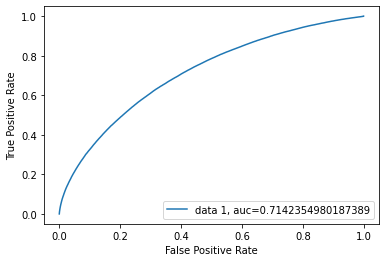

Precision: 0.5885829415715245
Recall: 0.05122090916529322
F1 score: 0.09424061249946235
Gini value: 0.42847099603747774


,Column,Amount
2,TaxiOut,3.030369
182,AirportToState_NJ,0.871672
3,AirportFromLat,0.840768
1,TaxiIn,0.692881
202,IsArrTimeNoonOrEvening,0.691082
...,...,...
141,AirportFromState_OR,-0.706836
48,PlaneAircraftType_Fixed Wing Single-Engine,-0.832504
104,PlaneManufacturer_SAAB-SCANIA,-0.836414
151,AirportFromState_WA,-0.849638


In [66]:
model1, _, importances = train_n_visualize_model(LogisticRegression, X_train, y_train, X_test, y_test)
importances

The AUC score of LogisticRegression is only 71.4%, so the model performs normally in this dataset, not so significant. I guess because the dataset doesn't have linear trending features to feed to the model.

In [72]:
del model1, _

### Decision Tree

Total time to train model: 96.75133037567139
Test score: 0.806138196798377
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.89      0.88      0.89    561118
     class 1       0.28      0.29      0.28     85554

    accuracy                           0.81    646672
   macro avg       0.58      0.59      0.59    646672
weighted avg       0.81      0.81      0.81    646672



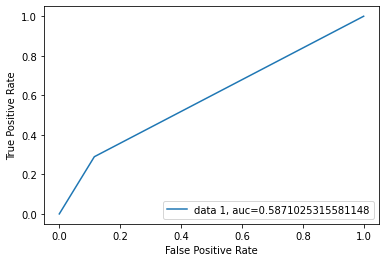

Precision: 0.2770466280619617
Recall: 0.2891156462585034
F1 score: 0.2829524980696085
Gini value: 0.17420506311622952


In [25]:
model2, _, importances = train_n_visualize_model(DecisionTreeClassifier, X_train, y_train, X_test, y_test)
importances

In [28]:
print(f"Depth of the tree: {model2.tree_.max_depth}")

Depth of the tree: 80


In [27]:
del model2, _

#### Naive Bayes

Total time to train model: 20.080333471298218
Test score: 0.7334001410384886
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.89      0.79      0.84    561081
     class 1       0.20      0.35      0.26     85551

    accuracy                           0.73    646632
   macro avg       0.55      0.57      0.55    646632
weighted avg       0.80      0.73      0.76    646632



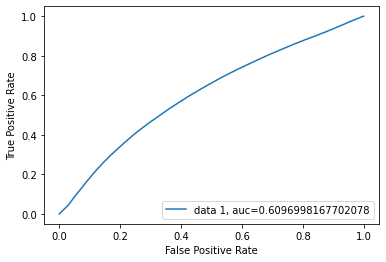

Precision: 0.20498569788219947
Recall: 0.35265514137765774
F1 score: 0.2592681711152742
Gini value: 0.21939963354041558


In [75]:
model3, _, importances = train_n_visualize_model(GaussianNB, X_train, y_train, X_test, y_test)
importances

In [ ]:
del model3, _

#### Support Vector Machine

In [40]:
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler

# model4 = SVC(gamma="auto", max_iter=200, probability=True)
# model4.fit(X_train, y_train)

# y_pred = model4.predict(X_test)
# y_pred_prob = model4.predict_proba(X_test).max(axis=1)

### Random Forest

Total time to train model: 739.2954885959625
Test score: 0.8726618749536086
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.88      0.99      0.93    561118
     class 1       0.61      0.11      0.18     85554

    accuracy                           0.87    646672
   macro avg       0.74      0.55      0.56    646672
weighted avg       0.84      0.87      0.83    646672



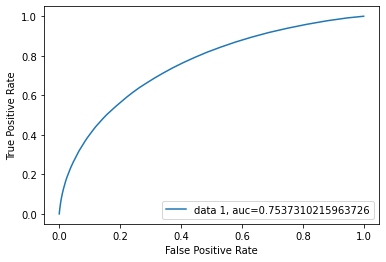

Precision: 0.6086573635008806
Recall: 0.10502138999929869
F1 score: 0.1791339367598389
Gini value: 0.5074620431927452


In [23]:
model5, _, importances = train_n_visualize_model(RandomForestClassifier, X_train, y_train, X_test, y_test)
importances

In [24]:
del model5, _

### Gradient Boosting

Total time to train model: 979.2217500209808
Test score: 0.8703167888497256
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.87      1.00      0.93    560505
     class 1       0.67      0.05      0.09     85793

    accuracy                           0.87    646298
   macro avg       0.77      0.52      0.51    646298
weighted avg       0.84      0.87      0.82    646298



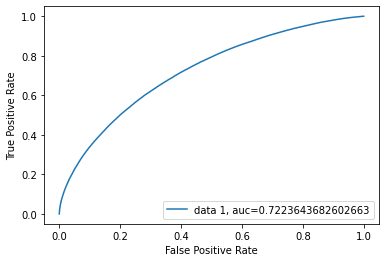

Precision: 0.6656066945606695
Recall: 0.046355763290711366
F1 score: 0.08667509371458461
Gini value: 0.4447287365205326


In [35]:
model6, _, importances = train_n_visualize_model(GradientBoostingClassifier, X_train, y_train, X_test, y_test)
importances

In [36]:
del model6, _

### LightGBM

In [18]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

In [22]:
num_round = 1000
param = param = {
#     "num_leaves": 31,
    "objective": "binary",
    "metric": "auc"
}
model7 = lgb.train(param, train_data, num_round, valid_sets=[test_data])

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 257130, number of negative: 1682586
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.115467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1461
[LightGBM] [Info] Number of data points in the train set: 1939716, number of used features: 204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.132561 -> initscore=-1.878505
[LightGBM] [Info] Start training from score -1.878505
[1]	valid_0's auc: 0.692042
[2]	valid_0's auc: 0.696543
[3]	valid_0's auc: 0.699246
[4]	valid_0's auc: 0.700817
[5]	valid_0's auc: 0.701671
[6]	valid_0's auc: 0.70317
[7]	valid_0's auc: 0.703788
[8]	valid_0's auc: 0.704567
[9]	valid_0's auc: 0.705603
[10]	valid_0's auc: 0.706899
[11]	valid_0's auc: 0.707542
[12]	valid_0's auc: 0.708517
[13]	valid_0's 

In [23]:
del model7

With the dataset not applying PCA and RFE, RandomForest achieves the highest performance by having the AUC score roughly is 75%.

When using LightGBM and training after 1000 epochs, it achieves 78% AUC score.

The NaiveBayes and DecisionTree algorithms performs worst in this dataset.

## PCA

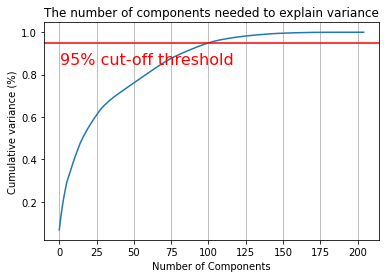

In [24]:
pca = PCA().fit(X_train)

fig, ax = plt.subplots()
plt.plot(np.cumsum(pca.explained_variance_ratio_))

plt.xlabel("Number of Components")
plt.ylabel("Cumulative variance (%)")
plt.title("The number of components needed to explain variance")

plt.axhline(y=0.95, color='r', linestyle="-")
plt.text(0.5, 0.85, "95% cut-off threshold", color="red", fontsize=16)
ax.grid(axis="x")
plt.show()

In [25]:
pca = PCA(n_components=100).fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

#### Logistic Regression

Total time to train model: 8.616173267364502
Test score: 0.8691794294480045
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.87      1.00      0.93    561118
     class 1       0.59      0.04      0.07     85554

    accuracy                           0.87    646672
   macro avg       0.73      0.52      0.50    646672
weighted avg       0.83      0.87      0.82    646672



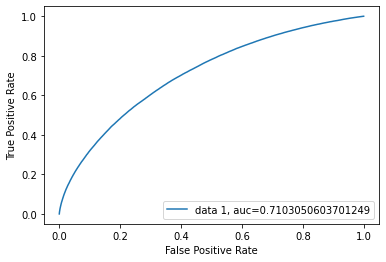

Precision: 0.5860951008645533
Recall: 0.03803445776936204
F1 score: 0.07143327552521239
Gini value: 0.4206101207402497


,Amount
99,1.274877
98,1.155866
83,0.962487
89,0.659802
81,0.634930
...,...
4,-0.460710
94,-0.642611
2,-0.885687
84,-1.031932


In [28]:
model1, _, importances = train_n_visualize_model(LogisticRegression, X_train_pca, y_train, X_test_pca, y_test)
importances

In [29]:
del model1, _

#### Decision Tree

Total time to train model: 801.577228307724
Test score: 0.7984836207536433
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.89      0.88      0.88    561118
     class 1       0.26      0.29      0.27     85554

    accuracy                           0.80    646672
   macro avg       0.58      0.58      0.58    646672
weighted avg       0.81      0.80      0.80    646672



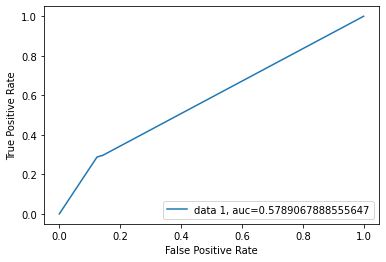

Precision: 0.26143498235852175
Recall: 0.28667274469925424
F1 score: 0.27347282387507177
Gini value: 0.15781357771112936


In [34]:
model2, _, importances = train_n_visualize_model(DecisionTreeClassifier, X_train_pca, y_train, X_test_pca, y_test, {"max_depth": 87})
importances

In [35]:
print(f"Depth of the tree: {model2.tree_.max_depth}")

Depth of the tree: 87


In [36]:
del model2, _

#### Naive Bayes

Total time to train model: 1.935903549194336
Test score: 0.8090623444018692
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.89      0.89      0.89    561031
     class 1       0.27      0.25      0.26     85667

    accuracy                           0.81    646698
   macro avg       0.58      0.57      0.57    646698
weighted avg       0.80      0.81      0.81    646698



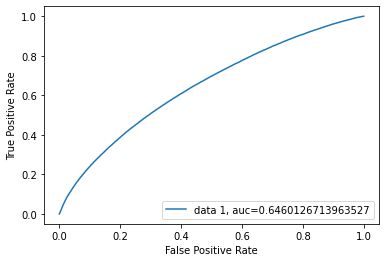

Precision: 0.26523034893828384
Recall: 0.2493258781094237
F1 score: 0.2570323170695018
Gini value: 0.2920253427927053


In [26]:
model3, _, importances = train_n_visualize_model(GaussianNB, X_train_pca, y_train, X_test_pca, y_test)
importances

In [27]:
del model3, _

#### Support Vector Machine

In [ ]:
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler

# model4 = SVC(gamma="auto", max_iter=200, probability=True)
# model4.fit(X_train, y_train)

# y_pred = model4.predict(X_test)
# y_pred_prob = model4.predict_proba(X_test).max(axis=1)

### Random Forest

Total time to train model: 4209.269877672195
Test score: 0.872434557240765
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.88      0.99      0.93    561118
     class 1       0.61      0.10      0.17     85554

    accuracy                           0.87    646672
   macro avg       0.74      0.54      0.55    646672
weighted avg       0.84      0.87      0.83    646672



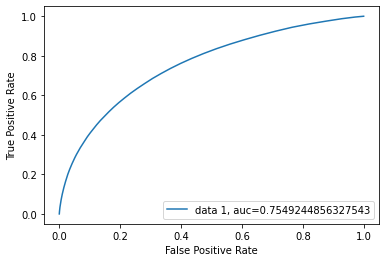

Precision: 0.6092980075698065
Recall: 0.09972648853355776
F1 score: 0.17139929889410085
Gini value: 0.5098489712655085


In [37]:
model5, _, importances = train_n_visualize_model(RandomForestClassifier, X_train_pca, y_train, X_test_pca, y_test)
importances

In [38]:
del model5, _

### Gradient Boosting

Total time to train model: 11605.647885799408
Test score: 0.8693973756982981
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.87      1.00      0.93    560951
     class 1       0.62      0.03      0.07     85621

    accuracy                           0.87    646572
   macro avg       0.75      0.52      0.50    646572
weighted avg       0.84      0.87      0.82    646572



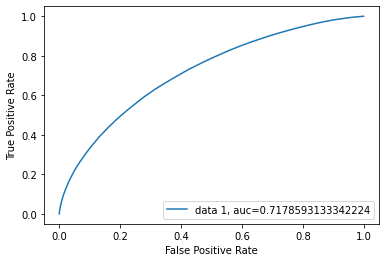

Precision: 0.6229371213703782
Recall: 0.03482790436925521
F1 score: 0.06596761348553226
Gini value: 0.43571862666844474


In [26]:
model6, _, importances = train_n_visualize_model(GradientBoostingClassifier, X_train_pca, y_train, X_test_pca, y_test)
importances

In [27]:
del model6, _

## SelectKBest

In [19]:
selectKBest = SelectKBest(k=20)
selectKBest.fit(X_train, y_train)
X_train_kbest = selectKBest.transform(X_train)
X_test_kbest = selectKBest.transform(X_test)

print("New shape after transforming: ", X_train_kbest.shape)

New shape after transforming:  (1938891, 20)


#### Logistic Regression

Total time to train model: 3.5558907985687256
Test score: 0.8687246440496489
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.87      1.00      0.93    560505
     class 1       0.58      0.04      0.07     85793

    accuracy                           0.87    646298
   macro avg       0.73      0.52      0.50    646298
weighted avg       0.83      0.87      0.82    646298



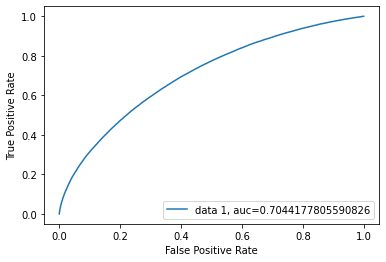

Precision: 0.5833625833625834
Recall: 0.03874441970790158
F1 score: 0.07266288487392203
Gini value: 0.4088355611181651


,Amount
1,2.793981
0,0.685153
17,0.680778
15,0.578163
8,0.552706
18,0.487426
19,0.435932
14,0.287842
7,0.285913
16,0.240917


In [20]:
model1, _, importances = train_n_visualize_model(LogisticRegression, X_train_kbest, y_train, X_test_kbest, y_test)
importances

In [ ]:
del model1, _

#### Decision Tree

Total time to train model: 18.337742567062378
Test score: 0.8014538185171546
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.88      0.89      0.89    560505
     class 1       0.24      0.22      0.23     85793

    accuracy                           0.80    646298
   macro avg       0.56      0.56      0.56    646298
weighted avg       0.80      0.80      0.80    646298



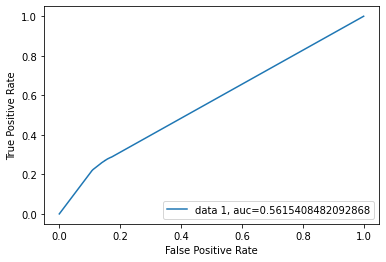

Precision: 0.23711442170983496
Recall: 0.22354970685254041
F1 score: 0.230132351000132
Gini value: 0.1230816964185737


In [23]:
model2, _, importances = train_n_visualize_model(DecisionTreeClassifier, X_train_kbest, y_train, X_test_kbest, y_test)
importances

In [24]:
print(f"Depth of the tree: {model2.tree_.max_depth}")

Depth of the tree: 58


All of the scores decrease slightly when using PCA, around 0.00x

In [25]:
del model2, _

#### Naive Bayes

Total time to train model: 1.0653023719787598
Test score: 0.7922475390609286
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.89      0.87      0.88    560505
     class 1       0.26      0.30      0.28     85793

    accuracy                           0.79    646298
   macro avg       0.57      0.58      0.58    646298
weighted avg       0.81      0.79      0.80    646298



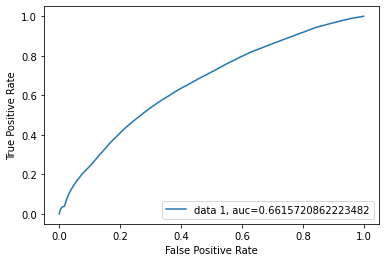

Precision: 0.2572192674058716
Recall: 0.2993251197650158
F1 score: 0.2766794160426655
Gini value: 0.3231441724446964


In [26]:
model3, _, importances = train_n_visualize_model(GaussianNB, X_train_kbest, y_train, X_test_kbest, y_test)
importances

Naive Bayes significantly decreases the recall score of late flight and increase not-late flight's recall

In [27]:
del model3, _

#### Support Vector Machine

In [28]:
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler

# model4 = SVC(gamma="auto", max_iter=200, probability=True)
# model4.fit(X_train, y_train)

# y_pred = model4.predict(X_test)
# y_pred_prob = model4.predict_proba(X_test).max(axis=1)

### Random Forest

Total time to train model: 351.16864585876465
Test score: 0.8468075098483981
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.88      0.95      0.92    560505
     class 1       0.33      0.14      0.20     85793

    accuracy                           0.85    646298
   macro avg       0.60      0.55      0.56    646298
weighted avg       0.81      0.85      0.82    646298



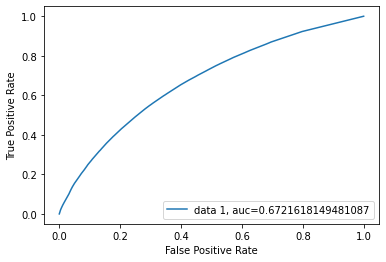

Precision: 0.32511050528043195
Recall: 0.14317018871003462
F1 score: 0.1987958632074708
Gini value: 0.34432362989621734


In [29]:
model5, _, importances = train_n_visualize_model(RandomForestClassifier, X_train_kbest, y_train, X_test_kbest, y_test)
importances

In [30]:
del model5, _

In [ ]:
del X_train_pca, X_test_pca

## RFE

In [28]:
from sklearn.feature_selection import RFE

In [29]:
def train_n_visualize_model_with_rfe(estimator, X_train, y_train, X_test, y_test, n_features_to_select=10, step=1):
    start = time.time()

    model = RFE(estimator, n_features_to_select=20, step=1)
    model.fit(X_train, y_train);

    print("Total time to train model:", time.time() - start)

    test_score = model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    print("Test score:", test_score)
    print("Precision matrix:")
    print(classification_report(y_test, y_pred, target_names=["class 0", "class 1"]))
    
    show_roc_curve_and_calc_precision_recall(y_test, y_pred, y_pred_prob)
    
    importances = None
    
    if isinstance(model, LogisticRegression):
        if type(X_train) != np.ndarray:
            importances = pd.DataFrame({"Column": training_columns, "Amount": model.coef_[0] }) 
            importances = importances.sort_values("Amount", ascending=False)
        else:
            total_features = X_train.shape[1]

            importances = pd.DataFrame({"Amount": model.coef_[0] }) 
            importances = importances.sort_values("Amount", ascending=False)
    
    return model, y_pred_prob, importances

### Logistic Regression

In [31]:
model1, _, importances = train_n_visualize_model_with_rfe(LogisticRegression(), X_train, y_train, X_test, y_test)
importances

KeyboardInterrupt: 

In [49]:
del model1, _

## GridSearchCV

In [32]:
from sklearn.model_selection import GridSearchCV

In [33]:
def train_n_visualize_model_with_grid_search_cv(modelClass, X_train, y_train, X_test, y_test, params):
    start = time.time()

    model2 = modelClass()
    model = GridSearchCV(model2, params)
    model.fit(X_train, y_train);

    print("Total time to train model:", time.time() - start)

    test_score = model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    print("Test score:", test_score)
    print("Precision matrix:")
    print(classification_report(y_test, y_pred, target_names=["class 0", "class 1"]))
    
    show_roc_curve_and_calc_precision_recall(y_test, y_pred, y_pred_prob)
    
    importances = None
    
    if isinstance(model, LogisticRegression):
        if type(X_train) != np.ndarray:
            importances = pd.DataFrame({"Column": training_columns, "Amount": model.coef_[0] }) 
            importances = importances.sort_values("Amount", ascending=False)
        else:
            total_features = X_train.shape[1]

            importances = pd.DataFrame({"Amount": model.coef_[0] }) 
            importances = importances.sort_values("Amount", ascending=False)
    
    return model, y_pred_prob, importances

In [34]:
params = {"n_estimators": [200, 250], "criterion": ["gini"], "max_features": ["auto", "sqrt", "log2"]}

model1, _, importances = train_n_visualize_model_with_grid_search_cv(
    RandomForestClassifier,
    X_train,
    y_train,
    X_test,
    y_test,
    params
)
importances


KeyboardInterrupt



# Summary
- The performance of the algorithms on the data is not remarkbly good. Only RandomForestClassifier is outstanding with 75% AUC score
- Dimensionality reduction methods:
    - NaiveBayes perform ineffectively when having many features. When not applying RFE or PCA, the performance is low compared to when applying them.
    - They don't positively impact other algorithms like DecisionTree, LogisticRegression, or RandomForestClassifier. In several case they could reduce the performance.
- I can't train SVM because it takes so long to finish (even longer than RandomForest).
- I can't show the the Residual and Homoscedasticity plots because this is a classification problem.
- This problem doesn't have any particular features strongly affect the label. It's quite understandable because if we can build high confidence model, it could innovate the flight lateness problem.